# Assessment 3 - A new tool for detecting prostate cancers
### Authors: Jeffrey Mills (28083938), Aruna Tillekeratne (27345483), Peter Tadich	(27695174)

---
### Table of Contents

[1. Exploratory Data Analysis](#1.-Exploratory-Data-Analysis)

[2. EDA Report](#2.-EDA-Report)

[3. XGBoost](#3.-XGBoost)

[4. Random Forest](#4.-Random-Forest)

[5. Deep Learning](#5.-Deep-Learning)

[6. Turbo Boost](#6.-Turbo-Boost)

[7. KNN Classification](#7.-KNN-Classification)

[8. Support Vector Machine](#8.-Support-Vector-Machine)

[9. Classification Trees](#9.-Classification-Trees)

[10. Rule-based Models](#10.-Rule-based-Models)

[11. Flexible Discriminant Analysis](#11.-Flexible-Discriminant-Analysis)

[12. Deep Learning](#12.-Deep-Learning)

[13. Ensemble the Predictions](#13.-Ensemble-the-Predictions)

[14. Classifier Summary Report](#14.-Classifier-Summary-Report)



[References](#References)

---

In [340]:
sessionInfo()

R version 3.3.1 (2016-06-21)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 8.1 x64 (build 9600)

locale:
[1] LC_COLLATE=English_Australia.1252  LC_CTYPE=English_Australia.1252   
[3] LC_MONETARY=English_Australia.1252 LC_NUMERIC=C                      
[5] LC_TIME=English_Australia.1252    

attached base packages:
 [1] parallel  splines   grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] h2o_3.10.0.8          statmod_1.4.27        sqldf_0.4-10         
 [4] gsubfn_0.6-6          proto_1.0.0           RSQLite_1.1          
 [7] pROC_1.8              doParallel_1.0.10     iterators_1.0.8      
[10] foreach_1.4.3         kernlab_0.9-25        earth_4.4.7          
[13] plotmo_3.3.2          TeachingDemos_2.10    plotrix_3.6-3        
[16] mda_0.4-9             class_7.3-14          C50_0.1.0-24         
[19] moments_0.14          tabplot_1.3           ffbase_0.12.3        
[22] ff_2.2-13             bit_

In [341]:
# disable scientific notation and set to 4 digits
options(scipen=999)
options(digits=4)
# set the default plot size
options(repr.plot.width = 6)
options(repr.plot.height = 4)
seed=123

In [342]:
# only install if not already installed
list.of.packages <- c("Rcpp" ,"ggplot2", "psych", "ROCR", "leaps", "glmnet", "caret", "caretEnsemble", "xgboost", "Matrix", 
                      "Ckmeans.1d.dp", "randomForest", "MASS", "DMwR", "ROSE", "plyr", "h2o", "gbm", "colorspace", "tabplot",
                    "ffbase", "moments", "C50", "mda", "earth", "kernlab", "doParallel", "pROC", "sqldf", "RSQLite",
                    "gsubfn", "proto")
new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages, repos="http://cran.uk.r-project.org", dependencies = TRUE)

In [343]:
# import ggplot for some of the more fancier plots

library("Rcpp")
library("ggplot2")
# import more comprehensive summary stats package
library(psych)
# import ROCR for easier model performance checking
library("ROCR")

library("caret")
library("caretEnsemble")
library("MASS")

library("xgboost")
library("Matrix")
library("Ckmeans.1d.dp")
library("randomForest")
library("DMwR")
library("ROSE")
library("plyr")
library("gbm")
library("colorspace")
library("tabplot")


library("moments")
library("C50")
library("mda")
library("earth")
library("kernlab")
library("doParallel")
library("pROC")
library("RSQLite")
library("sqldf")

library("ggplot2")
library("caret")
require("RSQLite")
require("sqldf")
library("gsubfn")
library("proto")

require("h2o")
require("ggplot2")


Warning message:
"package 'Rcpp' was built under R version 3.3.2"

In [344]:
# import local utilities.R file
source("./utilities.r")

## 1. Exploratory Data Analysis

In [345]:
prostate <- read.csv("./prostate.csv")

In [346]:
# Check the head of the dataframe
head(prostate)

,ID,ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
1,1,2,4,2,6,5,7,1,2,6,8,0
2,2,5,8,10,2,2,1,1,5,6,1,1
3,3,3,7,7,9,2,5,2,7,1,1,1
4,4,5,4,5,9,4,8,4,6,7,2,0
5,5,5,5,4,2,8,5,3,1,7,1,2
6,6,4,7,5,4,2,4,10,3,9,5,0


In [347]:
# Check structure of the datatypes
str(prostate)

'data.frame':	3000 obs. of  12 variables:
 $ ID    : int  1 2 3 4 5 6 7 8 9 10 ...
 $ ATT1  : int  2 5 3 5 5 4 2 10 4 2 ...
 $ ATT2  : int  4 8 7 4 5 7 1 5 9 1 ...
 $ ATT3  : int  2 10 7 5 4 5 5 4 4 2 ...
 $ ATT4  : int  6 2 9 9 2 4 7 8 2 10 ...
 $ ATT5  : int  5 2 2 4 8 2 10 4 6 10 ...
 $ ATT6  : int  7 1 5 8 5 4 3 7 6 2 ...
 $ ATT7  : int  1 1 2 4 3 10 7 3 8 2 ...
 $ ATT8  : int  2 5 7 6 1 3 1 6 8 5 ...
 $ ATT9  : int  6 6 1 7 7 9 10 7 4 1 ...
 $ ATT10 : int  8 1 1 2 1 5 7 3 3 3 ...
 $ Result: int  0 1 1 0 2 0 0 3 0 3 ...


We can drop the ID column as it adds no benefit to our modelling

In [348]:
prostate$ID <- NULL

Given that we know the **Result** variable is our target variable which represents one of 4 stages of the cancer (0 for curable, and 1 for tumour stage, 2 for node stage and 3 for incurable cancers) - this should be represented as a factor. 

In [349]:
prostate$Result <- as.factor(prostate$Result) 

In [350]:
# Let's check for incomplete observations
nrow(prostate[complete.cases(prostate),])

[1] 3000

In [351]:
# Check the proportions of each factor within the Result variable in our train set
print(table(prostate$Result))


   0    1    2    3 
1082 1080  642  196 


We have class imbalance. This will need to be addressed when training our models, potentially with some sampling techniques. 

In [352]:
round(describe(prostate), 3)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
ATT1,1.000,3000.000,5.815,2.661,6.000,5.769,2.965,2.000,10.000,8.000,0.097,-1.177,0.049
ATT2,2.000,3000.000,4.501,2.748,4.000,4.315,2.965,1.000,10.000,9.000,0.402,-0.980,0.050
ATT3,3.000,3000.000,5.830,2.655,6.000,5.788,2.965,2.000,10.000,8.000,0.099,-1.173,0.048
ATT4,4.000,3000.000,5.829,2.634,6.000,5.786,2.965,2.000,10.000,8.000,0.083,-1.165,0.048
ATT5,5.000,3000.000,5.755,2.622,6.000,5.694,2.965,2.000,10.000,8.000,0.129,-1.129,0.048
ATT6,6.000,3000.000,4.431,2.694,4.000,4.240,2.965,1.000,10.000,9.000,0.446,-0.930,0.049
ATT7,7.000,3000.000,4.479,2.741,4.000,4.297,2.965,1.000,10.000,9.000,0.393,-1.035,0.050
ATT8,8.000,3000.000,4.478,2.720,4.000,4.292,2.965,1.000,10.000,9.000,0.398,-0.962,0.050
ATT9,9.000,3000.000,4.446,2.678,4.000,4.254,2.965,1.000,10.000,9.000,0.428,-0.901,0.049
ATT10,10.000,3000.000,4.459,2.698,4.000,4.271,2.965,1.000,10.000,9.000,0.409,-0.940,0.049


No major signs of skewness in the predictor variables. That will help

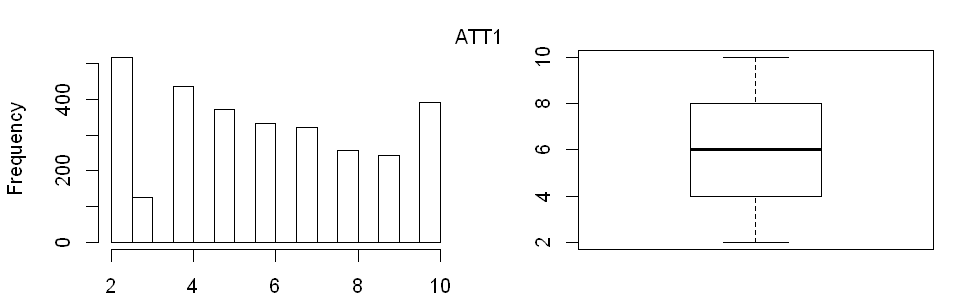

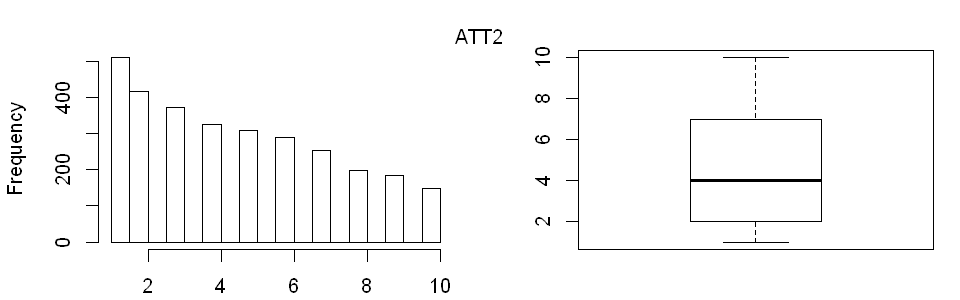

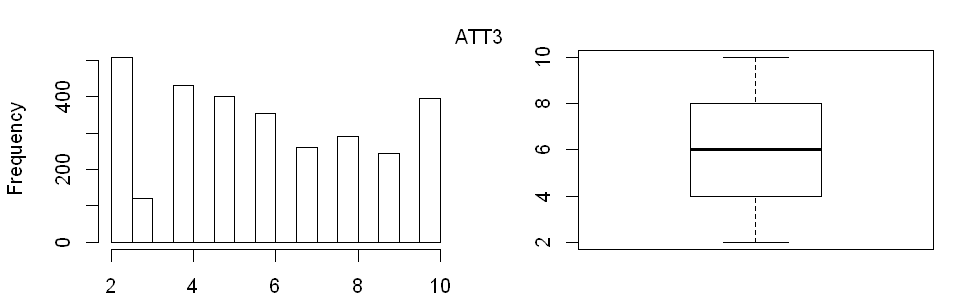

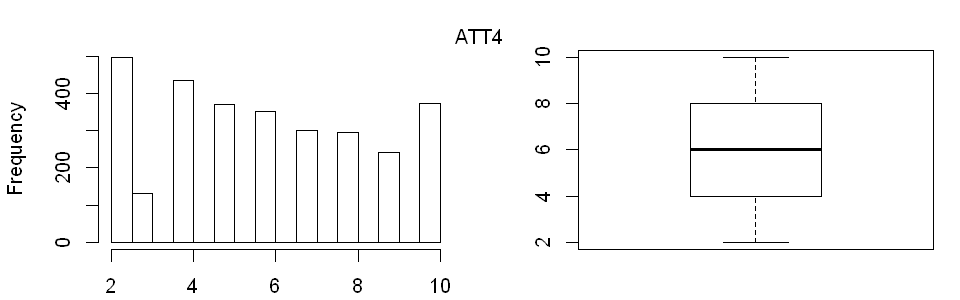

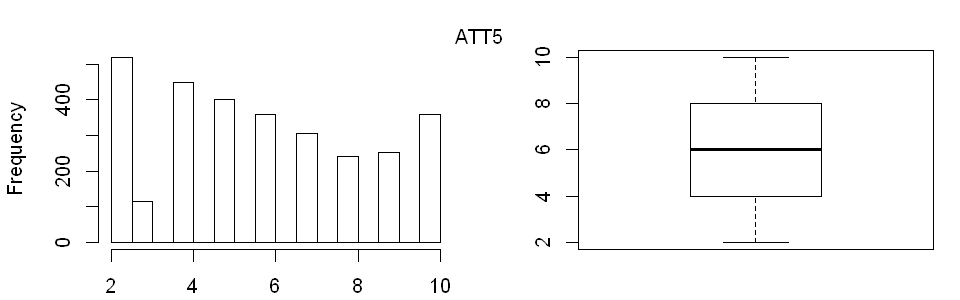

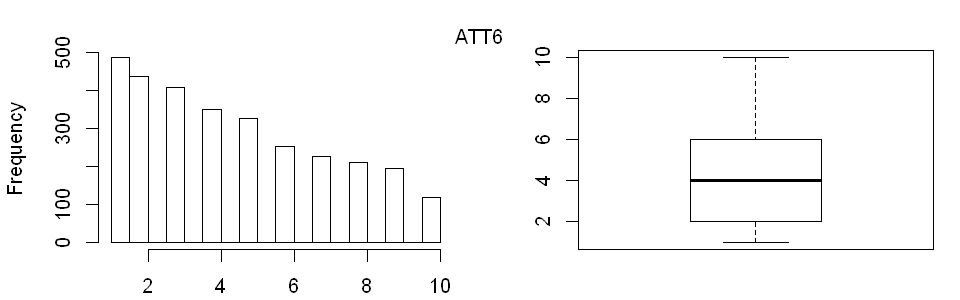

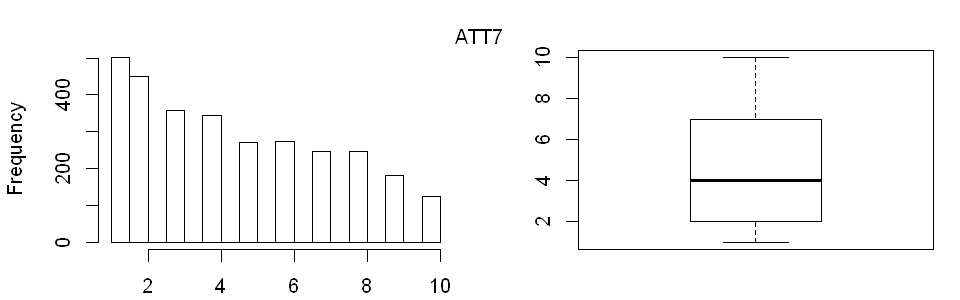

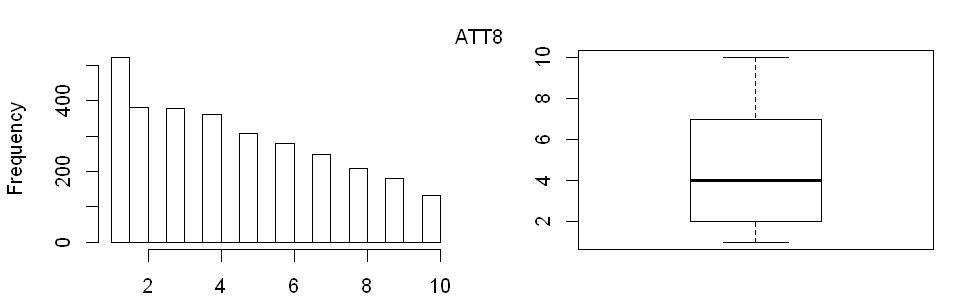

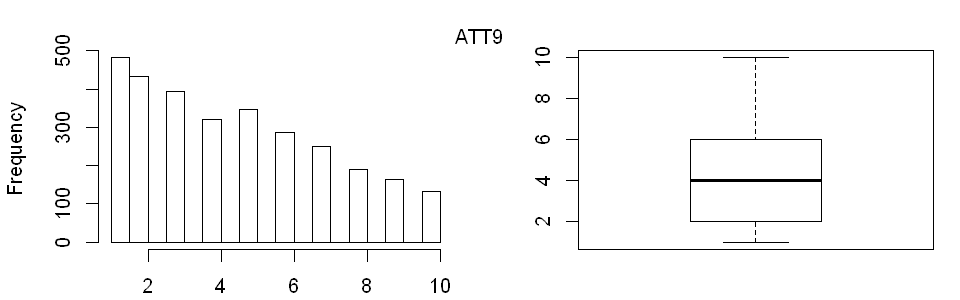

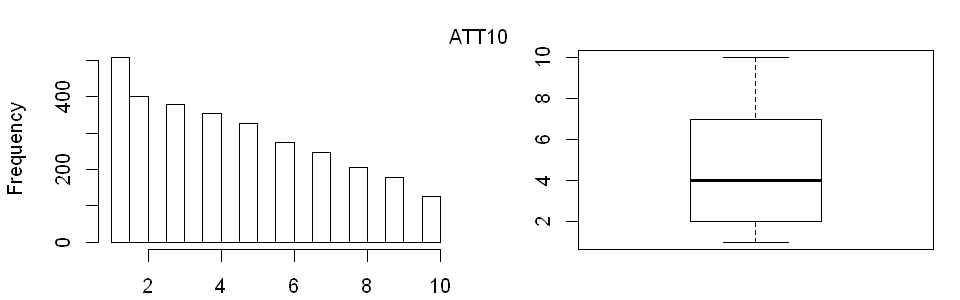

In [353]:
oldpar <- par() #this records all the default settings
par(mfrow=c(1,2)) # this makes to plots in one row
par(mar=c(2.1,4.1,2.1,1.1)) #BLTR
options(repr.plot.width=8, repr.plot.height=2.5)
for (i in names(prostate)) {
    if (i != "Result") {
        hist(prostate[[i]],xlab=NULL,main=NULL)
        boxplot(prostate[[i]], breaks = seq(0,10,1))
        mtext(i,side=3,line=-2, outer=TRUE)
    }
}
suppressWarnings( par(oldpar)) # Restore settings

### Let's show the distributions of each feature based on the class of the Result

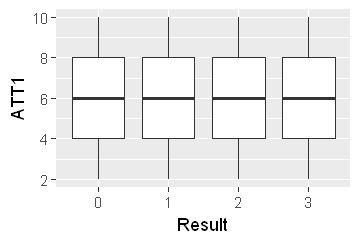

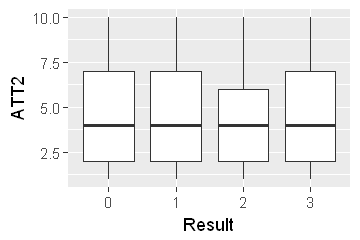

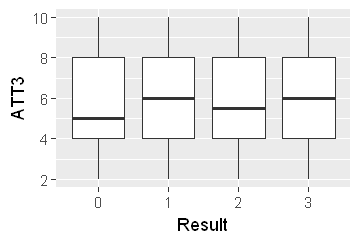

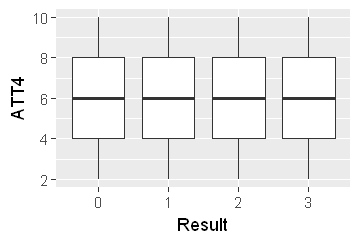

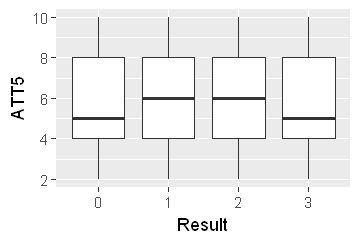

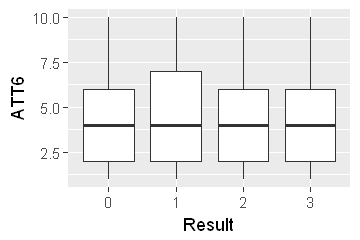

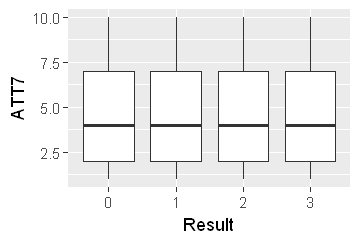

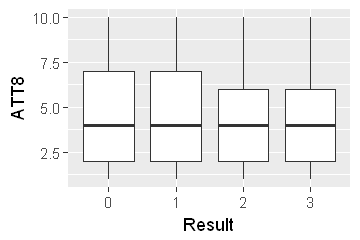

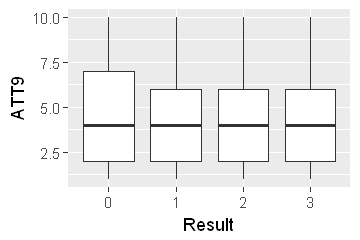

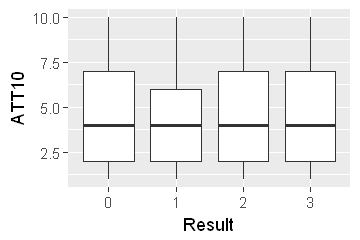

In [354]:
options(repr.plot.width = 3)
options(repr.plot.height = 2)
par(mfrow = c(2,2));
ggplot(prostate, aes(x = Result, y = ATT1)) + geom_boxplot()
ggplot(prostate, aes(x = Result, y = ATT2)) + geom_boxplot()
ggplot(prostate, aes(x = Result, y = ATT3)) + geom_boxplot()
ggplot(prostate, aes(x = Result, y = ATT4)) + geom_boxplot()
ggplot(prostate, aes(x = Result, y = ATT5)) + geom_boxplot()
ggplot(prostate, aes(x = Result, y = ATT6)) + geom_boxplot()
ggplot(prostate, aes(x = Result, y = ATT7)) + geom_boxplot()
ggplot(prostate, aes(x = Result, y = ATT8)) + geom_boxplot()
ggplot(prostate, aes(x = Result, y = ATT9)) + geom_boxplot()
ggplot(prostate, aes(x = Result, y = ATT10)) + geom_boxplot()
options(repr.plot.width = 6)
options(repr.plot.height = 4)

### Can we see any trends in classification between predictor variables?

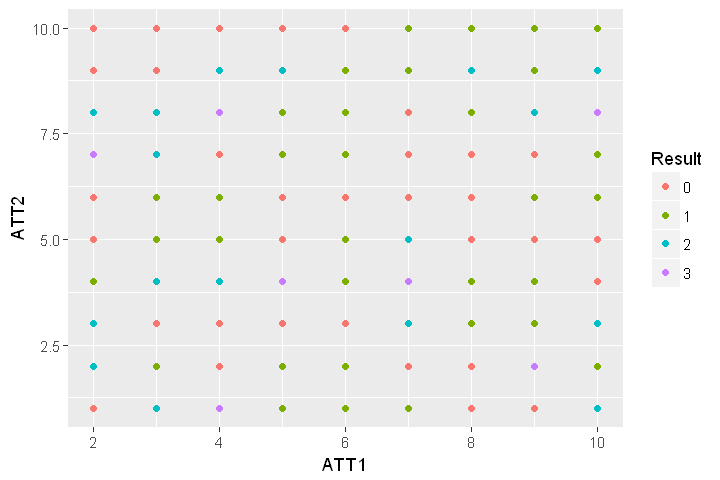

In [355]:
qplot(ATT1, ATT2, colour=Result, data=prostate)

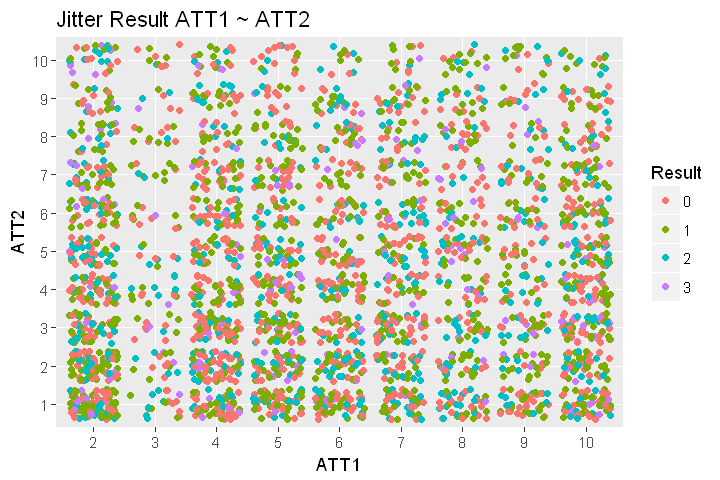

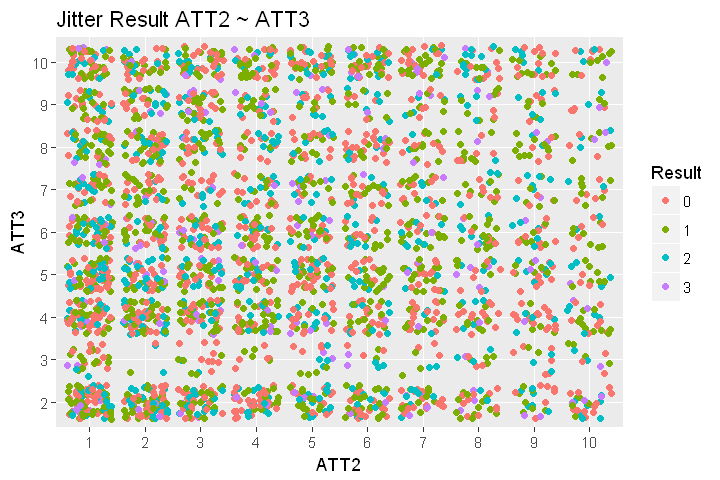

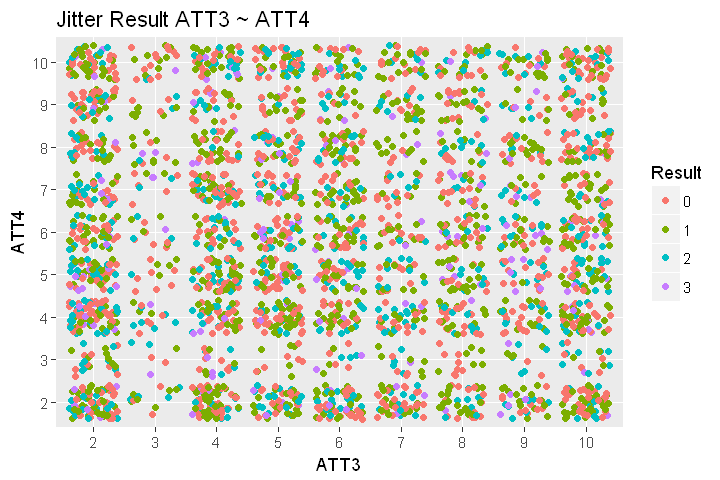

In [356]:
Udf.Utilities.Jitter(prostate,"ATT1","ATT2","Result")
Udf.Utilities.Jitter(prostate, "ATT2", "ATT3", "Result")
Udf.Utilities.Jitter(prostate, "ATT3", "ATT4", "Result")

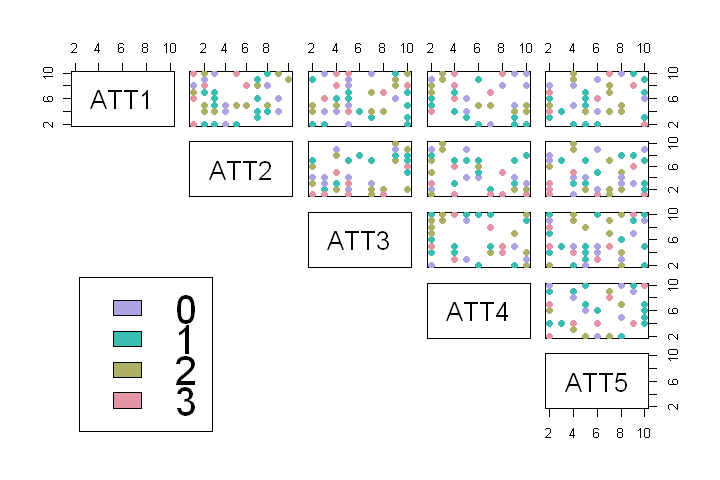

In [357]:
labels <- prostate[,11]
result_col <- rev(rainbow_hcl(4))[as.numeric(labels)]

# Plot a SPLOM:
# just show the first 50 records and the first 5 columns so we can visualise what is going on
pairs(prostate[1:50,1:5], col = result_col,
      lower.panel = NULL,
       cex.labels=2, pch=19, cex = 1.2)

# Add a legend
par(xpd = TRUE)
legend(x = 0.05, y = 0.4, cex = 2,
   legend = as.character(levels(labels)),
    fill = unique(result_col))
par(xpd = NA)

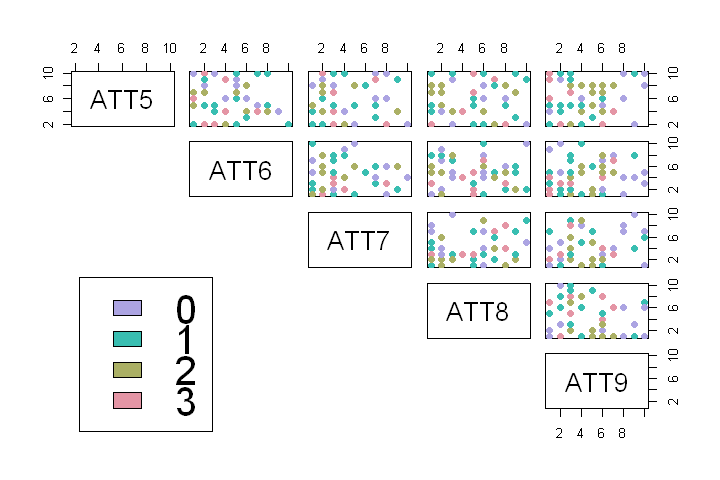

In [358]:
# now do the last 5 columns
pairs(prostate[1:50,5:9], col = result_col,
      lower.panel = NULL,
       cex.labels=2, pch=19, cex = 1.2)

# Add a legend
par(xpd = TRUE)
legend(x = 0.05, y = 0.4, cex = 2,
   legend = as.character(levels(labels)),
    fill = unique(result_col))
par(xpd = NA)

While Scatterplot matrices are not so good for looking at discrete variables - it still gives us an idea of how difficult this classification exercise will be

No visualisations so far have given any indication of signification relationships between the predictor variables and the resulting class of prostate cancer

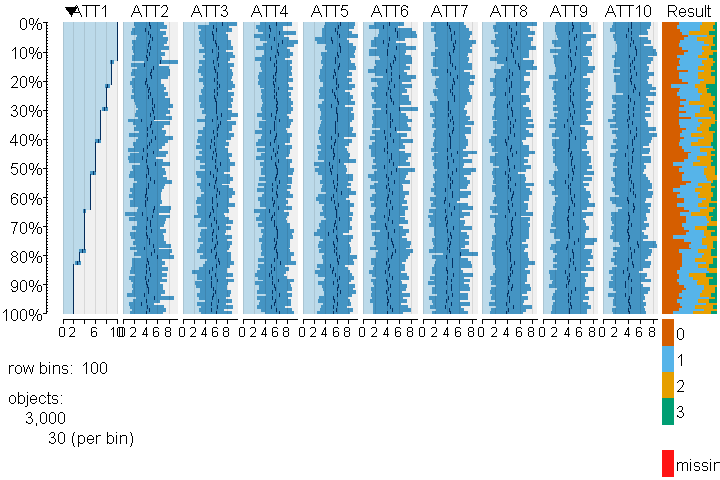

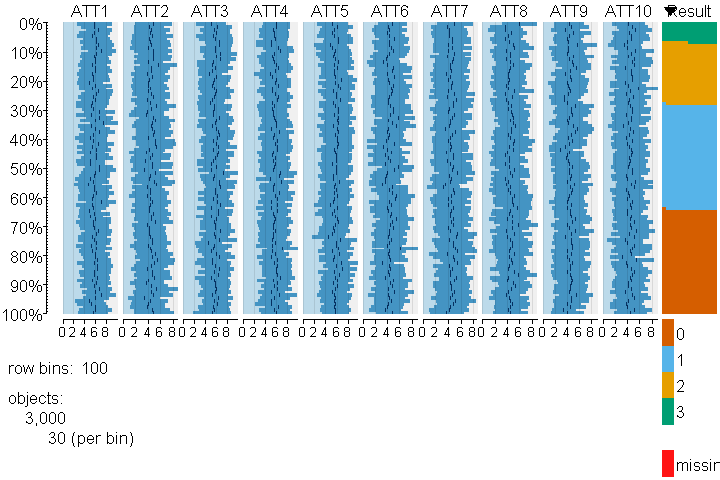

In [359]:
tableplot(prostate) # gives you the unsorted image below
tableplot(prostate, sortCol="Result") # gives you a sorted image according to class

Nothing standing out here either...

In [360]:
# Look for some near zero variance predictors from the original dataset.
nzv <- caret::nearZeroVar(prostate[,- c(1,ncol(prostate))],saveMetrics = TRUE)
nzv

,freqRatio,percentUnique,zeroVar,nzv
ATT2,1.2265,0.3333,0.0000,0.0000
ATT3,1.174,0.300,0.000,0.000
ATT4,1.14,0.30,0.00,0.00
ATT5,1.156,0.300,0.000,0.000
ATT6,1.1149,0.3333,0.0000,0.0000
ATT7,1.1109,0.3333,0.0000,0.0000
ATT8,1.3665,0.3333,0.0000,0.0000
ATT9,1.1132,0.3333,0.0000,0.0000
ATT10,1.2668,0.3333,0.0000,0.0000


We can see that we don't really have any zero variance predictors. Also all the features seem to have only about 30% unique data points out of the entire data set. The most frequent to the second most frequent value also seems to be spread across the feature space from around 1.2 to 1.1. <br />
This shows that the data is quite spread out. Unlikely that the features themselves would do anything.<br />

### Let's check the stacked bar plots
Per predictor (ignoring variable 'ID') bin the predictor value (in bins 1 to 10 in increments of 1), then normalize to create a stacked bar plot. Do this per response class.

In [361]:
prostateDatasetTrain <- prostate

In [362]:
# Based on the training dataset get the number of observations per class.
n0 <- dim(prostateDatasetTrain[prostateDatasetTrain[['Result']] == 0,])[1];
n1 <- dim(prostateDatasetTrain[prostateDatasetTrain[['Result']] == 1,])[1];
n2 <- dim(prostateDatasetTrain[prostateDatasetTrain[['Result']] == 2,])[1];
n3 <- dim(prostateDatasetTrain[prostateDatasetTrain[['Result']] == 3,])[1];

In [363]:
# Create empty matrices, 1 for each response class.
data <- rep(0,100);
class0 <- matrix(data, ncol=10, nrow=10);
class1 <- matrix(data, ncol=10, nrow=10);
class2 <- matrix(data, ncol=10, nrow=10);
class3 <- matrix(data, ncol=10, nrow=10);

In [508]:
predictorNames <- names(subset(prostateDatasetTrain, select = -c(Result)));

for(i in 0:3){ # For each class.
    df <- prostateDatasetTrain[prostateDatasetTrain[['Result']] == i, c(-11)];
    cnt <- 1;
    for(attributeName in predictorNames){ # For each predictor.
        #cat('Attribute name: ', attributeName, '\n');
        freqTable <- table(df[[attributeName]]);
        tableNames <- names(freqTable);
        for(colName in tableNames){
            #cat('   - Column name: ', as.numeric(colName), '[', freqTable[[colName]], ']','\n');
            if(i == 0){
                class0[as.numeric(colName), cnt] <- freqTable[[colName]];
            }
            if(i == 1){
                class1[as.numeric(colName), cnt] <- freqTable[[colName]];
            }
            if(i == 2){
                class2[as.numeric(colName), cnt] <- freqTable[[colName]];
            }
            if(i == 3){
                class3[as.numeric(colName), cnt] <- freqTable[[colName]];
            }
        }
        cnt <- cnt + 1;
    }
}

In [509]:
class0_cnt <- dim(prostateDatasetTrain[prostateDatasetTrain[['Result']] == 0, ])[1];
class1_cnt <- dim(prostateDatasetTrain[prostateDatasetTrain[['Result']] == 1, ])[1];
class2_cnt <- dim(prostateDatasetTrain[prostateDatasetTrain[['Result']] == 2, ])[1];
class3_cnt <- dim(prostateDatasetTrain[prostateDatasetTrain[['Result']] == 3, ])[1];

In [510]:
# Normalize.
class0 <- class0/class0_cnt;
class1 <- class1/class1_cnt;
class2 <- class2/class2_cnt;
class3 <- class3/class3_cnt;

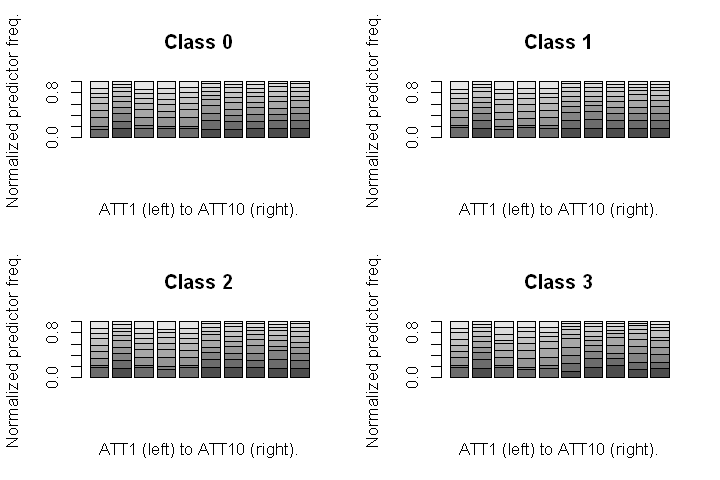

In [511]:
par(mfrow = c(2,2));
barplot(class0, main = 'Class 0', xlab = 'ATT1 (left) to ATT10 (right).', ylab = 'Normalized predictor freq.');
barplot(class1, main = 'Class 1', xlab = 'ATT1 (left) to ATT10 (right).', ylab = 'Normalized predictor freq.');
barplot(class2, main = 'Class 2', xlab = 'ATT1 (left) to ATT10 (right).', ylab = 'Normalized predictor freq.');
barplot(class3, main = 'Class 3', xlab = 'ATT1 (left) to ATT10 (right).', ylab = 'Normalized predictor freq.');

#### NOTE: Darkest shading equates to predictor value of 1. Lightest shading equates to predictor value of 10. 
The frequency of attribute value (normalized) per response class is shown in the above stacked bar plots. It is noted that within class bar plots there is visually noticeable difference between predictors however across response class per predictor there is visually little difference. The exception to this is response class 3, predictor 'ATT8' has a higher proportion of values at '1' than the other response classes.

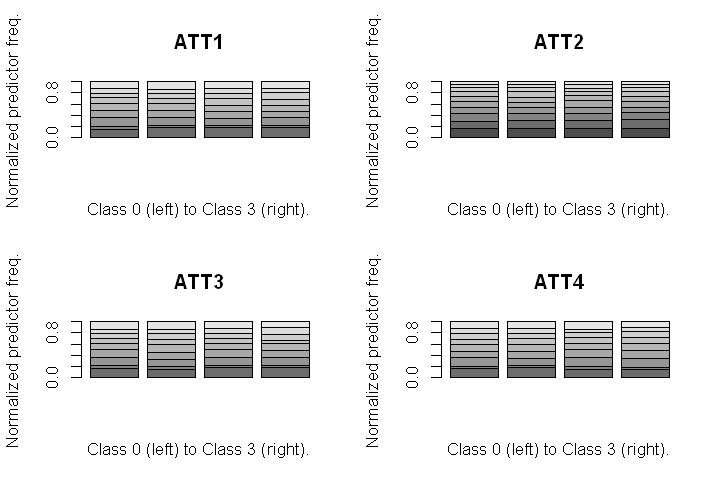

In [512]:
par(mfrow = c(2,2));
barplot(matrix(c(class0[,1],class1[,1],class2[,1],class3[,1]), ncol=4, nrow=10), main = 'ATT1', xlab = 'Class 0 (left) to Class 3 (right).', ylab = 'Normalized predictor freq.');
barplot(matrix(c(class0[,2],class1[,2],class2[,2],class3[,2]), ncol=4, nrow=10), main = 'ATT2', xlab = 'Class 0 (left) to Class 3 (right).', ylab = 'Normalized predictor freq.');
barplot(matrix(c(class0[,3],class1[,3],class2[,3],class3[,3]), ncol=4, nrow=10), main = 'ATT3', xlab = 'Class 0 (left) to Class 3 (right).', ylab = 'Normalized predictor freq.');
barplot(matrix(c(class0[,4],class1[,4],class2[,4],class3[,4]), ncol=4, nrow=10), main = 'ATT4', xlab = 'Class 0 (left) to Class 3 (right).', ylab = 'Normalized predictor freq.');

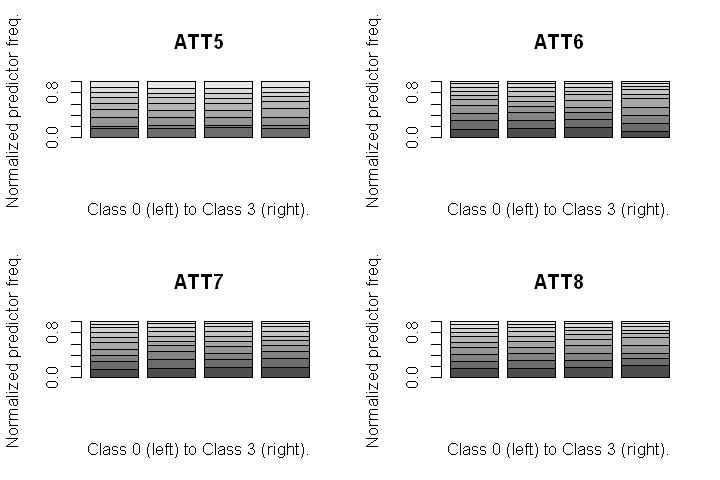

In [513]:
par(mfrow = c(2,2));
barplot(matrix(c(class0[,5],class1[,5],class2[,5],class3[,5]), ncol=4, nrow=10), main = 'ATT5', xlab = 'Class 0 (left) to Class 3 (right).', ylab = 'Normalized predictor freq.');
barplot(matrix(c(class0[,6],class1[,6],class2[,6],class3[,6]), ncol=4, nrow=10), main = 'ATT6', xlab = 'Class 0 (left) to Class 3 (right).', ylab = 'Normalized predictor freq.');
barplot(matrix(c(class0[,7],class1[,7],class2[,7],class3[,7]), ncol=4, nrow=10), main = 'ATT7', xlab = 'Class 0 (left) to Class 3 (right).', ylab = 'Normalized predictor freq.');
barplot(matrix(c(class0[,8],class1[,8],class2[,8],class3[,8]), ncol=4, nrow=10), main = 'ATT8', xlab = 'Class 0 (left) to Class 3 (right).', ylab = 'Normalized predictor freq.');

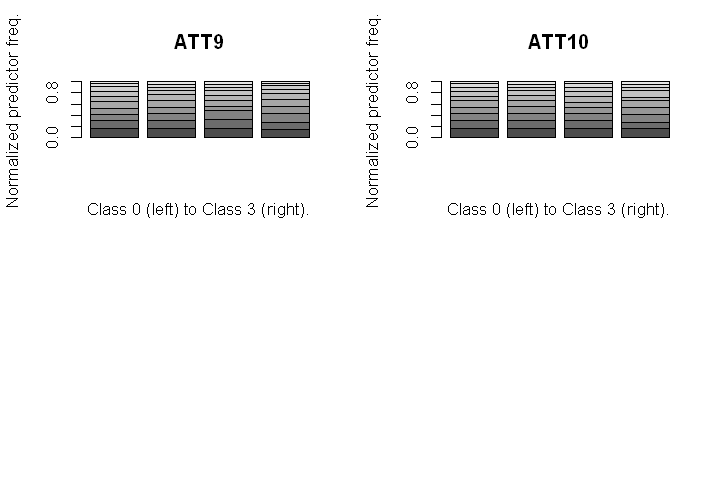

In [514]:
par(mfrow = c(2,2));
barplot(matrix(c(class0[,9],class1[,9],class2[,9],class3[,9]), ncol=4, nrow=10), main = 'ATT9', xlab = 'Class 0 (left) to Class 3 (right).', ylab = 'Normalized predictor freq.');
barplot(matrix(c(class0[,10],class1[,10],class2[,10],class3[,10]), ncol=4, nrow=10), main = 'ATT10', xlab = 'Class 0 (left) to Class 3 (right).', ylab = 'Normalized predictor freq.');

The above stacked bar plots are normalized frequencies of predictor values across response class 0 to class 3. Visually there is no noticeable across class differences (within predictor), each response class visually appears to have the same normalized proportion of the predictor values. The noticeable exception is predictor 'ATT8'. Shown in predictor 'ATT8' stacked bar plot the normalized proportions of the lower predictor values (1, 2) are increasing from response class 0 to response class 3.

---
# 2. EDA Report

- No univariate outliers were identified using Tukey's test or the Hampel identifier.
- The bar graph of response variable 'Result' versus response class shows the distribution is unbalanced.
- All histograms have a general trend of decreasing frequency (count) per increase in the independent variable.
- 'ATT1' and 'ATT3' show the same boxplot across classes. This was also picked up in summary statistics. This suggests that these two predictors maybe non-informative.
- The correlation data shows there is little relationship between predictors as all off diagonal cells have strengths less than absolute 0.1.

When investigating stacked bar plots of normalized frequencies of predictor values across response class 0 to class 3 the only noticeable exception was predictor 'ATT8'. The stacked bar plot of the normalized proportions of the predictor value for predictor 'ATT8' increases from response class 0 to response class 3 at the lower predictor values (1, 2).

### Dealing with class imbalance
One of the first things that was highlighted with this dataset is the class imbalance in the Result variable. There is a low representation of the 4th class, which could pose some issues for our classification methods, and possibly lead to the creation of a model that is "cheating" by simply disregarding the infrequent class to maximise prediction accuracy. This could be a problem if the actual test set used does not have the same imbalance of classes present, so our approach was to keep this firmly in mind and attempt to try various sampling methods for each model. Up-sampling seemed to prove the most effective since it resulted in more data to work with, as apposed to down-sampling which would leave us data-poor.

## Train/Test split
Before we do anything, dedicate 20% of our data to an unseen Test set.

In [371]:
# 20% of the sample size
smp_size <- floor(0.8 * nrow(prostate))

set.seed(seed)
train_ind <- sample(seq_len(nrow(prostate)), size = smp_size)

train <- prostate[train_ind, ]
test <- prostate[-train_ind, ]

In [372]:
actual <-  as.numeric(test$Result)-1

In [373]:
actual_factor <- actual
actual_factor[actual_factor==0] <- "curable"
actual_factor[actual_factor==1] <- "tumour"
actual_factor[actual_factor==2] <- "node"
actual_factor[actual_factor==3] <- "incurable"

---
# 3. XGBoost

In [374]:
# create an upsample of training to obtain an even split of classes
# note that other sampling methods (down, SMOTE) were tried with less success
xg_train <- Udf.Utilities.UpSample(train)

xg_test <- test

In [375]:
# Check the proportions of each factor within the Result variable
w <- table(xg_train$Result)
w


  0   1   2   3 
876 876 876 876 

In [376]:
# set the target for XGBoost to a numeric range from 0 - 3
xg_train.y <- as.numeric(xg_train$Result)-1
xg_test.y <- as.numeric(test$Result)-1

In [377]:
# store the actuals for future comparison
#actual <- xg_test.y

In [378]:
# convert to matrix for boosting method
xg_train <- sparse.model.matrix(Result ~ ., data = xg_train)
dtrain <- xgb.DMatrix(data=xg_train, label=xg_train.y)

In [379]:
xg_test <- sparse.model.matrix(Result ~ ., data = xg_test)
dtest <- xgb.DMatrix(data=xg_test, label=xg_test.y)

In [380]:
watchlist <- list(xg_train=dtrain)

In [381]:
# set default params to be used if we don't have the compute power to perform this gridsearch
nrounds <- 500
max_depth <- 6
eta <- 0.1
colsample_bytree <- 0.9
subsample <- 0.9
gamma <- 0
min_child_weight <- 1

In [382]:
# cross validate to select optimal value for number of rounds
set.seed(seed)
n_rounds.cv <- 1000
params <- list(booster = "gbtree", objective = "multi:softmax",
               num_class = 4, eval_metric = 'merror',
               max_depth = max_depth, eta = eta,
               colsample_bytree = colsample_bytree, subsample = subsample, min_child_weight = min_child_weight)

In [383]:
bst.cv <- xgb.cv(params, dtrain, n_rounds.cv, nfold = 10, metrics = {'merror'},
                 print.every.n = 20, prediction = TRUE)

[0]	train-merror:0.508879+0.012468	test-merror:0.624680+0.024307
[20]	train-merror:0.176560+0.008523	test-merror:0.468025+0.029982
[40]	train-merror:0.100583+0.002541	test-merror:0.418943+0.031163
[60]	train-merror:0.061802+0.002610	test-merror:0.406106+0.027163
[80]	train-merror:0.036307+0.002331	test-merror:0.396708+0.024365
[100]	train-merror:0.021911+0.001830	test-merror:0.384998+0.024580
[120]	train-merror:0.013667+0.001957	test-merror:0.381288+0.025276
[140]	train-merror:0.007325+0.001342	test-merror:0.372162+0.028310
[160]	train-merror:0.004027+0.000748	test-merror:0.369870+0.031357
[180]	train-merror:0.002030+0.000477	test-merror:0.369019+0.029462
[200]	train-merror:0.001237+0.000484	test-merror:0.369307+0.028689
[220]	train-merror:0.000634+0.000473	test-merror:0.369020+0.025303
[240]	train-merror:0.000190+0.000401	test-merror:0.368169+0.024413
[260]	train-merror:0.000000+0.000000	test-merror:0.367882+0.024541
[280]	train-merror:0.000000+0.000000	test-merror:0.366731+0.021838
[

In [384]:
n_rounds.train <- which.min(bst.cv$dt[, test.merror.mean])
n_rounds.train

[1] 306

In [385]:
# create the model
bst <- xgb.train(   params              = params, 
                    data                = dtrain, 
                    nrounds             = n_rounds.train, 
                    verbose             = 1,
                    watchlist           = watchlist,
                    maximize            = FALSE
)

[0]	xg_train-merror:0.501712
[1]	xg_train-merror:0.408961
[2]	xg_train-merror:0.368721
[3]	xg_train-merror:0.327911
[4]	xg_train-merror:0.316210
[5]	xg_train-merror:0.291381
[6]	xg_train-merror:0.277397
[7]	xg_train-merror:0.275114
[8]	xg_train-merror:0.261986
[9]	xg_train-merror:0.261701
[10]	xg_train-merror:0.247717
[11]	xg_train-merror:0.235160
[12]	xg_train-merror:0.221747
[13]	xg_train-merror:0.216039
[14]	xg_train-merror:0.216039
[15]	xg_train-merror:0.209475
[16]	xg_train-merror:0.202340
[17]	xg_train-merror:0.196347
[18]	xg_train-merror:0.190354
[19]	xg_train-merror:0.185502
[20]	xg_train-merror:0.182078
[21]	xg_train-merror:0.177511
[22]	xg_train-merror:0.171518
[23]	xg_train-merror:0.164954
[24]	xg_train-merror:0.162671
[25]	xg_train-merror:0.152683
[26]	xg_train-merror:0.145263
[27]	xg_train-merror:0.143836
[28]	xg_train-merror:0.137557
[29]	xg_train-merror:0.133562
[30]	xg_train-merror:0.132135
[31]	xg_train-merror:0.129281
[32]	xg_train-merror:0.121861
[33]	xg_train-merror

In [386]:
# generate predictions from model
pred_xgb <- predict(bst, xg_test);

In [387]:
confusionMatrix(pred_xgb, actual)

Confusion Matrix and Statistics

          Reference
Prediction  0  1  2  3
         0 87 83 60 15
         1 82 78 60 18
         2 40 38 21  2
         3  5  5  6  0

Overall Statistics
                                        
               Accuracy : 0.31          
                 95% CI : (0.273, 0.349)
    No Information Rate : 0.357         
    P-Value [Acc > NIR] : 0.992882      
                                        
                  Kappa : -0.02         
 Mcnemar's Test P-Value : 0.000704      

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.407    0.382    0.143   0.0000
Specificity             0.591    0.596    0.823   0.9717
Pos Pred Value          0.355    0.328    0.208   0.0000
Neg Pred Value          0.642    0.652    0.747   0.9401
Prevalence              0.357    0.340    0.245   0.0583
Detection Rate          0.145    0.130    0.035   0.0000
Detection Prevalence    0.408    0.397    0.168   0.0267
Balan

In [388]:
feature.importance <- xgb.importance(dimnames(xg_train)[[2]], model = bst)
head(feature.importance)

,Feature,Gain,Cover,Frequence
1,ATT3,0.104013392229815,0.0884387812879234,0.100707140393239
2,ATT9,0.102409110367457,0.116503945866794,0.103535701966195
3,ATT4,0.102311142280264,0.0900530928434779,0.0998620213866851
4,ATT6,0.101093972495696,0.101818313112935,0.100793377026561
5,ATT10,0.100559832080534,0.106793830794048,0.100758882373232
6,ATT2,0.0995691186445694,0.10838137342493,0.100569161779924


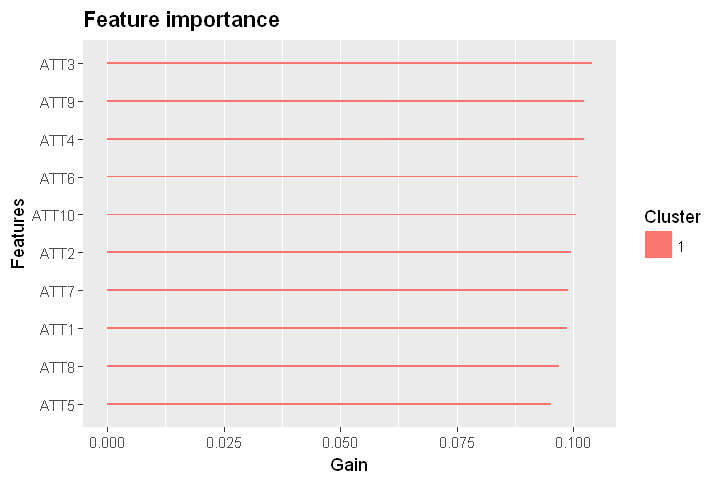

In [389]:
xgb.plot.importance(feature.importance)

## Cross Validate further parameters for XGBoost using GridSearch

In [390]:
xgbGrid <- expand.grid(
    nrounds = c(100, 300, 500, 1000),
    max_depth = c(1, 3, 5, 7),
    eta = c(0.001, 0.01, 0.1),
    gamma = c(0, 1),
    colsample_bytree = c(1, 0.9, 0.8),
    min_child_weight = c(1, 2, 3),
    subsample = c(1, 0.9, 0.8)
)

In [391]:
xgbTrControl <- trainControl(
    method = "repeatedcv",
    number = 5,
    repeats = 2,
    verboseIter = FALSE,
    returnData = FALSE,
    allowParallel = TRUE
)

In [392]:
xg_train <- Udf.Utilities.UpSample(train)
xg_train$Result <- as.numeric(xg_train$Result)-1
for(i in c(1:ncol(xg_train))) {
    xg_train[,i] <- as.numeric(xg_train[,i])
}

In [393]:
set.seed(seed)

# This is computationaly expensive - takes about an hour
if(FALSE){
    xgbTrain <- train(
        x = as.matrix(xg_train[, ! names(xg_train) %in% c('Result')]), 
        y = xg_train$Result,
        objective = 'multi:softmax',
        trControl = xgbTrControl,
        tuneGrid = xgbGrid,
        method = 'xgbTree',
        num_class = 4,
        eval_metric = 'merror'
    )
}

In [394]:
#    eta max_depth gamma colsample_bytree min_child_weight subsample nrounds   RMSE Rsquared  RMSESD RsquaredSD
#91  0.10         7     0              0.9                1       0.9     500 0.8699   0.4890 0.06079    0.06009
#92  0.10         7     0              0.9                1       0.9    1000 0.8716   0.4888 0.03330    0.03463
#39  0.01         7     0              0.9                1       0.9    5000 0.8744   0.4849 0.07411    0.07273
#42  0.01         7     0              0.9                2       0.9    5000 0.8748   0.4857 0.06031    0.05941
#102 0.10         7     1              0.9                1       0.9    5000 0.8762   0.4858 0.03332    0.03191

The results of the tuning process were a little suprising, I didn't expect the max-depth of the trees to be so deep, especially considering we only have 10 features to play with. I thought this might lead to overfitting, but apparently not.

In [395]:
nrounds <- 500
max_depth <- 7
eta <- 0.1
colsample_bytree <- 0.9
subsample <- 0.9
gamma <- 0
min_child_weight <- 1

In [396]:
# Alter the params based on the best performing set of params abvove
params <- list(booster = "gbtree", objective = "multi:softmax",
               num_class = 4, eval_metric = 'merror',
               max_depth = max_depth, eta = eta,
               colsample_bytree = colsample_bytree, subsample = subsample,
               gamma = gamma, min_child_weight = min_child_weight)

In [397]:
bst.cv <- xgb.cv(params, dtrain, nrounds, nfold = 10, metrics = {'merror'},
                 print.every.n = 20, prediction = TRUE)

[0]	train-merror:0.432996+0.014986	test-merror:0.580206+0.025382
[20]	train-merror:0.086251+0.004525	test-merror:0.425523+0.019752
[40]	train-merror:0.035610+0.002237	test-merror:0.395839+0.023937
[60]	train-merror:0.014967+0.001113	test-merror:0.380974+0.027215
[80]	train-merror:0.006025+0.001495	test-merror:0.377847+0.022059
[100]	train-merror:0.001934+0.000460	test-merror:0.366425+0.021308
[120]	train-merror:0.000698+0.000328	test-merror:0.364147+0.015419
[140]	train-merror:0.000254+0.000250	test-merror:0.362161+0.017983
[160]	train-merror:0.000000+0.000000	test-merror:0.362164+0.018406
[180]	train-merror:0.000000+0.000000	test-merror:0.358165+0.017872
[200]	train-merror:0.000000+0.000000	test-merror:0.358162+0.020775
[220]	train-merror:0.000000+0.000000	test-merror:0.361022+0.019295
[240]	train-merror:0.000000+0.000000	test-merror:0.359025+0.020951
[260]	train-merror:0.000000+0.000000	test-merror:0.357597+0.017982
[280]	train-merror:0.000000+0.000000	test-merror:0.358457+0.016925
[

In [398]:
n_rounds.train <- which.min(bst.cv$dt[, test.merror.mean])
n_rounds.train

[1] 259

In [399]:
# create the model
bst <- xgb.train(   params              = params, 
                    data                = dtrain, 
                    nrounds             = n_rounds.train, 
                    verbose             = 1,
                    watchlist           = watchlist,
                    maximize            = FALSE
)

[0]	xg_train-merror:0.405251
[1]	xg_train-merror:0.329909
[2]	xg_train-merror:0.283676
[3]	xg_train-merror:0.257705
[4]	xg_train-merror:0.242865
[5]	xg_train-merror:0.215753
[6]	xg_train-merror:0.204623
[7]	xg_train-merror:0.188642
[8]	xg_train-merror:0.175514
[9]	xg_train-merror:0.167808
[10]	xg_train-merror:0.160959
[11]	xg_train-merror:0.147260
[12]	xg_train-merror:0.134989
[13]	xg_train-merror:0.126712
[14]	xg_train-merror:0.119007
[15]	xg_train-merror:0.112158
[16]	xg_train-merror:0.105879
[17]	xg_train-merror:0.103596
[18]	xg_train-merror:0.094749
[19]	xg_train-merror:0.089041
[20]	xg_train-merror:0.087043
[21]	xg_train-merror:0.086758
[22]	xg_train-merror:0.079053
[23]	xg_train-merror:0.076769
[24]	xg_train-merror:0.073630
[25]	xg_train-merror:0.072774
[26]	xg_train-merror:0.071062
[27]	xg_train-merror:0.067637
[28]	xg_train-merror:0.061929
[29]	xg_train-merror:0.059361
[30]	xg_train-merror:0.058790
[31]	xg_train-merror:0.057078
[32]	xg_train-merror:0.055080
[33]	xg_train-merror

In [400]:
# generate predictions from model
pred_xgb_tune <- predict(bst, xg_test);

In [401]:
confusionMatrix(pred_xgb_tune, actual)

Confusion Matrix and Statistics

          Reference
Prediction  0  1  2  3
         0 91 79 61 16
         1 85 86 62 16
         2 34 33 21  2
         3  4  6  3  1

Overall Statistics
                                        
               Accuracy : 0.332         
                 95% CI : (0.294, 0.371)
    No Information Rate : 0.357         
    P-Value [Acc > NIR] : 0.907         
                                        
                  Kappa : 0.008         
 Mcnemar's Test P-Value : 0.0000696     

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.425    0.422    0.143  0.02857
Specificity             0.596    0.588    0.848  0.97699
Pos Pred Value          0.368    0.345    0.233  0.07143
Neg Pred Value          0.652    0.664    0.753  0.94198
Prevalence              0.357    0.340    0.245  0.05833
Detection Rate          0.152    0.143    0.035  0.00167
Detection Prevalence    0.412    0.415    0.150  0.02333
Balan

Accuracy was improved with tuning

# 4. Random Forest
(Jeffrey Mills)

Given that our EDA failed to show up any strong correlations between variables, we are a little unsure if there are any strong predictors (relatively) in the dataset. We need to ensure that our tree gives a fair consideration to all of the features to ensure we don't head towards a local minima. This is where the Random Forst approach will come in. The method takes random samples of predictors at each split and only one is chosen from this set. So we can have decisions where the most optimal/important feature is not included for consideration. 

In [402]:
# set the train set
rforest_train <- train

In [403]:
# perform up-sampling using caret
control <- trainControl(method="repeatedcv", number=10, repeats=3, sampling = "up")
metric <- "Accuracy"
set.seed(seed)
tunegrid <- expand.grid(.mtry=c(2, 3, 4))
rf_default <- train(Result ~., data=rforest_train, 
                    method="rf", metric=metric, tuneGrid=tunegrid, trControl=control, ntree=1000)
#print(rf_default)

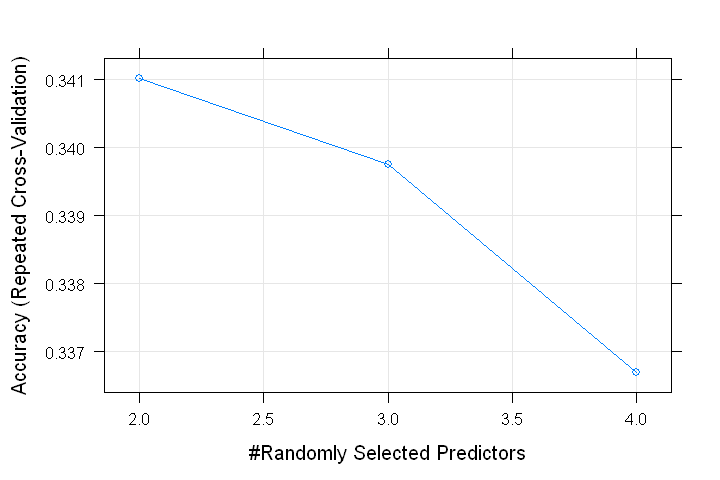

In [404]:
plot(rf_default)

In [405]:
pred_rf <- predict(rf_default, test)

In [406]:
confusionMatrix(pred_rf, actual)

Confusion Matrix and Statistics

          Reference
Prediction  0  1  2  3
         0 92 91 66 17
         1 95 89 66 17
         2 25 23 14  1
         3  2  1  1  0

Overall Statistics
                                          
               Accuracy : 0.325           
                 95% CI : (0.288, 0.364)  
    No Information Rate : 0.357           
    P-Value [Acc > NIR] : 0.953           
                                          
                  Kappa : -0.016          
 Mcnemar's Test P-Value : 0.00000000000358

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.430    0.436   0.0952  0.00000
Specificity             0.549    0.551   0.8918  0.99292
Pos Pred Value          0.346    0.333   0.2222  0.00000
Neg Pred Value          0.635    0.655   0.7523  0.94128
Prevalence              0.357    0.340   0.2450  0.05833
Detection Rate          0.153    0.148   0.0233  0.00000
Detection Prevalence    0.443    0.445   0.105

In [407]:
print(importance(rf_default$finalModel,type = 2))

      MeanDecreaseGini
ATT1             249.3
ATT2             266.5
ATT3             254.7
ATT4             257.4
ATT5             248.5
ATT6             261.7
ATT7             257.3
ATT8             260.3
ATT9             263.2
ATT10            259.2


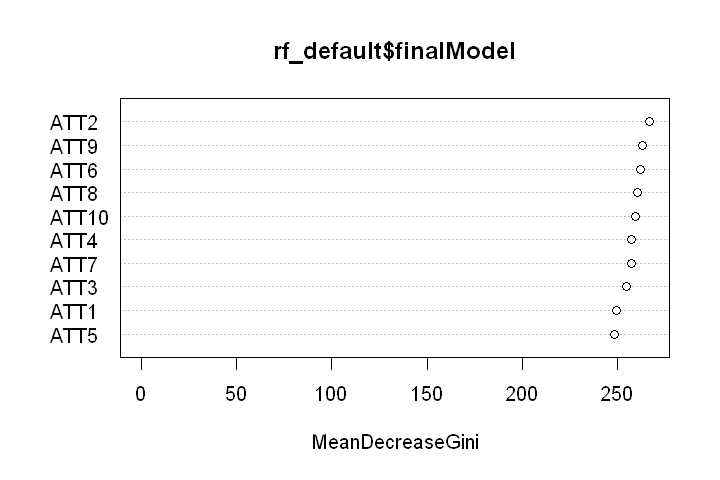

In [408]:
options(repr.plot.width = 6)
options(repr.plot.height = 4)
varImpPlot(rf_default$finalModel)

## Cross Validation for Random Forest feature selection 

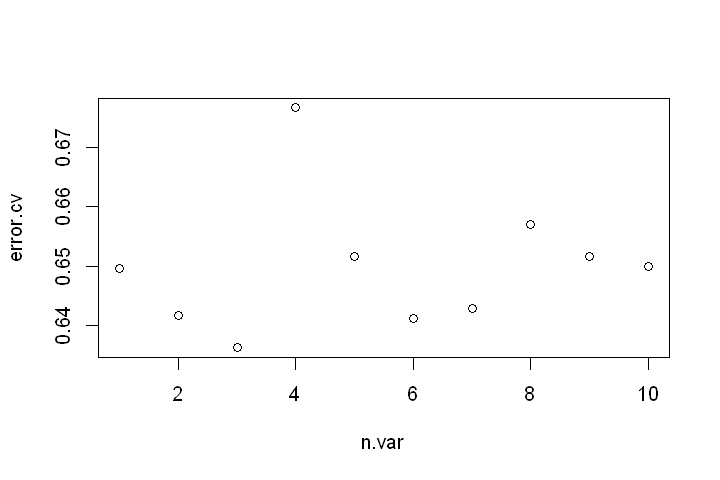

In [409]:
x <- train
x$Result <- NULL
y <- train$Result

rf.cv <- rfcv(x, y, cv.fold=10, step=0.9)

set.seed(seed)
with(rf.cv, plot(n.var, error.cv))

Ok, this is telling us that a model with all features may not be best. Let's try retrain the model without the lowest importance features and rerun the predictions

In [410]:
rforest <- randomForest(Result ~ . - ATT1 - ATT3 - ATT5, data = rforest_train, mtry=4, ntree=10000, sampsize=1000)
rforest


Call:
 randomForest(formula = Result ~ . - ATT1 - ATT3 - ATT5, data = rforest_train,      mtry = 4, ntree = 10000, sampsize = 1000) 
               Type of random forest: classification
                     Number of trees: 10000
No. of variables tried at each split: 4

        OOB estimate of  error rate: 63.08%
Confusion matrix:
    0   1  2 3 class.error
0 408 414 46 0      0.5300
1 387 443 46 0      0.4943
2 206 254 35 0      0.9293
3  68  84  9 0      1.0000

In [411]:
pred_rf <- predict(rforest, test)

In [412]:
confusionMatrix(pred_rf, actual)

Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3
         0 102  88  71  14
         1 102 100  68  21
         2  10  16   8   0
         3   0   0   0   0

Overall Statistics
                                       
               Accuracy : 0.35         
                 95% CI : (0.312, 0.39)
    No Information Rate : 0.357        
    P-Value [Acc > NIR] : 0.648        
                                       
                  Kappa : 0.012        
 Mcnemar's Test P-Value : NA           

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.477    0.490   0.0544   0.0000
Specificity             0.552    0.518   0.9426   1.0000
Pos Pred Value          0.371    0.344   0.2353      NaN
Neg Pred Value          0.655    0.663   0.7544   0.9417
Prevalence              0.357    0.340   0.2450   0.0583
Detection Rate          0.170    0.167   0.0133   0.0000
Detection Prevalence    0.458    0.485   0.0567   

### Gradient Boosted Trees vs. RandomForest discussion

We have chosen two variants on the Decision Tree paradigm for a our first models. While Gradient Boosted trees and Random Forests are based on the same concept, their behaviours were shown to be quite different.

Given the less 'random' nature of Boosting, more effort is required to tune the many parameters to ensure there is no overfitting - whilst RandomForests are pretty good in this area out of the box. The only parameter to tune is really the number of features that are randomly selected from at each step in the tree creation. After tuning we saw that the relatively low number of 2 was selected - the default is the square root of the number of predictors, so 3 or 4 in our case.

Both options gave us the ability to see feature importance and agreed that ATT1 and ATT5 were not very significant. Dropping these improved the RandomForest accuracy.

Both models performed faily well, but XGBoost took a lot more effort to get to this accuracy. The best choice for this project is a little subjective (even after we've run both):

Dimensiality - Boosted trees are the method of choice in low (< 100) dimension settings. Random forests are the better choice in high-dimension settings.

Ideally, at the end of the project we would like to be able to convey how the prediction model is working under the hood to doctors who use it. They will be able to bring domain expertise to the problem if they can see how the model is working. This is one benefit of using a Tree based model. This is reduced somewhat as we bring in aspects such as Boosting and Random Forests, however.

After using the method, we were unable to improve the predictive accuracy much beyond 34%. Much of this was due to not having the compute power to effectively tune the hyperparameters. Given we were very unsure about our data, we needed to tune heavily, especially since we were seeing many cases of train error rates much lower than test. Avoiding over-fitting proved to be the demise of this method.

---
# 6. Turbo Boost
(Aruna Tillekeratne)

In [413]:
# Set training and test sets
tr_ <- train
ts_ <- test
actual <- ts_$Result

In [414]:
# PCA
pc_ <- Udf.Utilities.Prcomp(tr_[,-ncol(tr_)],nComps = 2)

pcObj_ <- pc_$prcompObj # Get object 

tr_ <- cbind(tr_,pc_$components) # bind to features.

In [415]:
# do the same to the test set
pc_ts <- Udf.Utilities.Prcomp(ts_[,-ncol(ts_)],nComps = 2)

pcObj_ts<- pc_ts$prcompObj # Get object 

ts_ <- cbind(ts_,pc_ts$components) # bind to features.

In [416]:
# Control method
ctrl_ <- trainControl(method = "cv", number = 5, sampling = "up")
mdl.xgb <- train(Result ~ . , data = tr_, method = "xgbTree", trControl = ctrl_)

In [417]:
pred_xgb_prcomp <- predict(mdl.xgb, ts_)

In [418]:
confusionMatrix(actual, pred_xgb_prcomp)

Confusion Matrix and Statistics

          Reference
Prediction  0  1  2  3
         0 72 63 50 29
         1 75 62 50 17
         2 53 49 32 13
         3 16  8  7  4

Overall Statistics
                                        
               Accuracy : 0.283         
                 95% CI : (0.248, 0.321)
    No Information Rate : 0.36          
    P-Value [Acc > NIR] : 1.000         
                                        
                  Kappa : -0.016        
 Mcnemar's Test P-Value : 0.127         

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.333    0.341   0.2302  0.06349
Specificity             0.630    0.660   0.7505  0.94227
Pos Pred Value          0.336    0.304   0.2177  0.11429
Neg Pred Value          0.627    0.697   0.7638  0.89558
Prevalence              0.360    0.303   0.2317  0.10500
Detection Rate          0.120    0.103   0.0533  0.00667
Detection Prevalence    0.357    0.340   0.2450  0.05833
Balan

In [419]:
mdl.gbm <- train(Result ~ . , data = tr_,method = "gbm", trControl = ctrl_)
pred_gbm <- predict(mdl.gbm, ts_)

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.3863             nan     0.1000    0.0009
     2        1.3845             nan     0.1000   -0.0009
     3        1.3829             nan     0.1000   -0.0004
     4        1.3812             nan     0.1000   -0.0002
     5        1.3797             nan     0.1000   -0.0006
     6        1.3783             nan     0.1000   -0.0002
     7        1.3765             nan     0.1000    0.0002
     8        1.3750             nan     0.1000    0.0001
     9        1.3739             nan     0.1000   -0.0002
    10        1.3728             nan     0.1000   -0.0000
    20        1.3610             nan     0.1000   -0.0000
    40        1.3428             nan     0.1000    0.0001
    60        1.3285             nan     0.1000   -0.0010
    80        1.3158             nan     0.1000   -0.0016
   100        1.3051             nan     0.1000   -0.0010
   120        1.2949             nan     0.1000   -0.0018
   140        

In [420]:
confusionMatrix(actual, pred_gbm)

Confusion Matrix and Statistics

          Reference
Prediction  0  1  2  3
         0 67 61 53 33
         1 60 65 56 23
         2 43 51 35 18
         3 10 11  8  6

Overall Statistics
                                        
               Accuracy : 0.288         
                 95% CI : (0.252, 0.326)
    No Information Rate : 0.313         
    P-Value [Acc > NIR] : 0.91454       
                                        
                  Kappa : 0.007         
 Mcnemar's Test P-Value : 0.00139       

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.372    0.346   0.2303   0.0750
Specificity             0.650    0.663   0.7500   0.9442
Pos Pred Value          0.313    0.319   0.2381   0.1714
Neg Pred Value          0.707    0.689   0.7417   0.8690
Prevalence              0.300    0.313   0.2533   0.1333
Detection Rate          0.112    0.108   0.0583   0.0100
Detection Prevalence    0.357    0.340   0.2450   0.0583
Balan

---
# 7. KNN Classification
(Jeffrey Mills)

In [421]:
# set the training set
knn_train <- train

In [422]:
set.seed(seed)
# create the trainControl for cross-validation
ctrl <- trainControl(method="repeatedcv",repeats = 5)
# create the model. Cross validation is on the K parameter
knnFit <- train(Result ~ ., 
                data = knn_train, 
                method = "knn", 
                trControl = ctrl, 
                preProcess = c("center","scale"),
                tuneLength = 20)

In [423]:
knnFit

k-Nearest Neighbors 

2400 samples
  10 predictor
   4 classes: '0', '1', '2', '3' 

Pre-processing: centered (10), scaled (10) 
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 2158, 2162, 2161, 2161, 2160, 2160, ... 
Resampling results across tuning parameters:

  k   Accuracy  Kappa     
   5  0.3327     0.0031361
   7  0.3398     0.0052320
   9  0.3456     0.0067162
  11  0.3454    -0.0001731
  13  0.3512     0.0059354
  15  0.3529     0.0050043
  17  0.3526     0.0021470
  19  0.3519    -0.0011296
  21  0.3497    -0.0065015
  23  0.3519    -0.0044468
  25  0.3467    -0.0140404
  27  0.3473    -0.0147368
  29  0.3413    -0.0244012
  31  0.3466    -0.0170929
  33  0.3448    -0.0208928
  35  0.3495    -0.0144542
  37  0.3500    -0.0144856
  39  0.3491    -0.0164655
  41  0.3541    -0.0095169
  43  0.3521    -0.0132306

Accuracy was used to select the optimal model using  the largest value.
The final value used for the model was k = 41. 

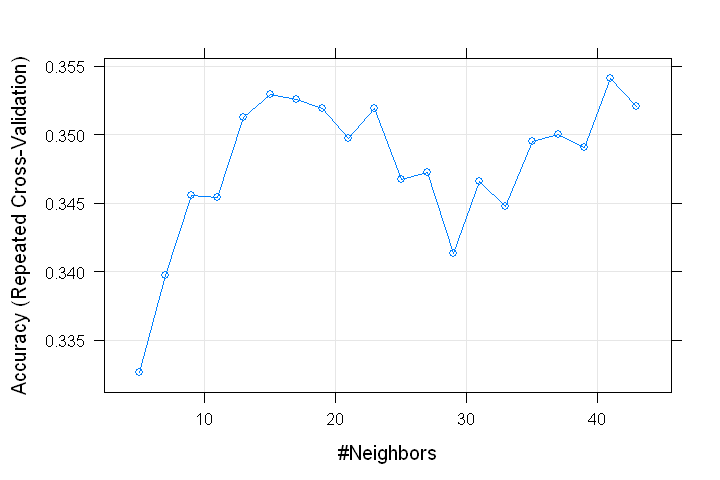

In [424]:
#Plotting yields Number of Neighbours Vs accuracy (based on repeated cross validation)
plot(knnFit)

An interesting plot. I'm not 100% sure we are out of a local minimum, but that's Ok for now, let's check the result

In [425]:
pred_knn <- predict(knnFit,newdata = test )

In [426]:
confusionMatrix(actual, pred_knn )

Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3
         0 101 109   4   0
         1  91 110   3   0
         2  77  66   4   0
         3  21  13   1   0

Overall Statistics
                                             
               Accuracy : 0.358              
                 95% CI : (0.32, 0.398)      
    No Information Rate : 0.497              
    P-Value [Acc > NIR] : 1                  
                                             
                  Kappa : 0.019              
 Mcnemar's Test P-Value : <0.0000000000000002

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.348    0.369  0.33333       NA
Specificity             0.635    0.689  0.75680   0.9417
Pos Pred Value          0.472    0.539  0.02721       NA
Neg Pred Value          0.510    0.525  0.98234       NA
Prevalence              0.483    0.497  0.02000   0.0000
Detection Rate          0.168    0.183  0.00667   0.0000
De

Accuracy of 35.8% is very good out of the box - I'm a little concerned with how poorly it did on Class 3, however -  we may need to look at up-sampling

---
# 8. Support Vector Machine
(Peter Tadich)

In [427]:
prostateDatasetTrain_modified <- train
prostateDatasetTest_modified<- test

#### Response variable to factor.

In [428]:
# Encode response 'Result' as a factor variable to perform classification.
prostateDatasetTrain_modified[['Result']] <- as.factor(prostateDatasetTrain_modified[['Result']]);
# Do the same for the test set.
prostateDatasetTest_modified[['Result']] <- as.factor(prostateDatasetTest_modified[['Result']]);

#### Predictor matrix

In [429]:
# All predictors to a matrix.
x <- data.matrix(subset(prostateDatasetTrain_modified, select = -c(Result)));

In [430]:
x[1:5,];

,ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10
863,5,8,10,9,2,2,8,6,2,3
2365,4,4,2,4,4,1,3,7,3,9
1227,7,4,9,2,4,2,3,9,9,8
2647,5,5,7,2,4,1,8,10,1,7
2818,10,1,2,5,7,2,8,5,9,5


In [431]:
# Do the same for the test set.
x_test <- data.matrix(subset(prostateDatasetTest_modified, select = -c(Result)));

In [432]:
x_test[1:5,];

,ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10
1,2,4,2,6,5,7,1,2,6,8
11,10,3,7,9,9,5,2,3,2,6
12,8,2,4,2,2,2,4,8,6,10
13,7,2,10,7,10,1,3,6,2,1
14,9,10,9,3,4,6,9,6,4,2


#### Response vector

In [433]:
# Response vector.
y <- prostateDatasetTrain_modified[['Result']];

In [434]:
# Do the same for the test set.
y_test <- prostateDatasetTest_modified[['Result']];

#### Dealing with class imbalance

In [435]:
# Down-sampling.
#xy <- downSample(x, y, list = FALSE, yname = 'Result');

# Up-sampling.
set.seed(seed)
xy <- upSample(x, y, list = FALSE, yname = 'Result');

In [436]:
# The classes are now balanced.
table(xy$Result);


  0   1   2   3 
876 876 876 876 

In [437]:
# Randomize the classes as the classes are now blocks. First class takes rows 1 to n, second class n+1 to m etc...
indices <- sample(1:dim(xy)[1], dim(xy)[1], replace=FALSE);
if(length(unique(indices)) != dim(xy)[1]){
    cat('Warning: non-unique indices created.');
}

In [438]:
xy <- data.frame(xy)[indices, ];
rownames(xy) <- NULL;
head(xy, 5);

,ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
1,6,5,2,4,2,8,2,4,3,7,3
2,4,9,8,9,2,2,4,8,1,7,2
3,5,5,9,2,6,5,1,9,3,1,2
4,7,6,4,4,9,6,8,9,3,1,3
5,10,5,4,8,4,7,3,6,7,3,3


In [439]:
cat('Number of samples: ', dim(xy)[1]);

Number of samples:  3504

#### Create predictor matrix, response vector

In [440]:
# Predictor matrix - all predictors to a matrix.
x <- data.matrix(subset(xy, select = -c(Result)));

In [441]:
# Response vector.
y <- xy[['Result']];

#### Setup dataframe for recursive feature elimination

In [442]:
# Create the 'predictor' vectors.
predictors <- subset(xy, select = -c(Result)); # Drop 'Result'

In [443]:
# Create the 'response' vector.
response <- xy$Result;

In [444]:
# Combine the 'response' with the 'predictors'.
adData <- predictors;
adData$Result <- response;

### SVM setup

In [445]:
# Create a split vector to be used to create a training set and a test set.
set.seed(658);
split <- createDataPartition(response, p = .8, list = FALSE);

# Now create 'training' and 'test' datasets.
training <- adData[ split, ];
testing  <- adData[-split, ];

# Get the 'predictor' names.
predVars <- names(adData)[!(names(adData) %in% c("Result"))];

# Create the cross-validation files as a list to use with different functions.
set.seed(294);
index <- createMultiFolds(training$Result, times = 5);

## The candidate set of the number of predictors to evaluate
varSeq <- seq(9,length(predVars),1);

In [446]:
rank <- function (object, x, y) 
{
    cat('rank\n')
    cat('Model type: ', object$modelType, '\n')
    vimp <- varImp(object, scale = FALSE)$importance
    cat('vimp colnames: ', colnames(vimp), '\n')
    cat('levels (before): ', levels(y), '\n')
    # Rename by name: change "0" to "X0"
    levels(y)[levels(y)=="0"] <- "X0"
    levels(y)[levels(y)=="1"] <- "X1"
    levels(y)[levels(y)=="2"] <- "X2"
    levels(y)[levels(y)=="3"] <- "X3"
    cat('levels (after): ', levels(y), '\n')
    if (object$modelType == "Regression") {
        vimp <- vimp[order(vimp[, 1], decreasing = TRUE), , drop = FALSE]
    }
    else {
        if (all(levels(y) %in% colnames(vimp))) {
            avImp <- apply(vimp[, levels(y), drop = TRUE], 1, 
                mean)
            vimp$Overall <- avImp
        }
    }
    vimp$var <- rownames(vimp)
    cat(dim(vimp), '\n')
    vimp
}

In [447]:
selectSize <- function (x, metric, maximize) 
    {
        cat('selectSize\n')
        cat(dim(x), '\n')
        cat(names(x), '\n')
        cat(metric, '\n');
        best <- if (maximize) 
            which.max(x[, metric])
        else which.min(x[, metric])
        cat('Optimal number of predictors: ', min(x[best, "Variables"]), '\n')
        min(x[best, "Variables"])
    }

In [448]:
selectVar <- function (y, size) 
{
    cat('selectVar:\n')
    cat(dim(y), '\n')
    cat(names(y), '\n')
    cat('size: ', size, '\n')
    finalImp <- ddply(y[, c("Overall", "var")], .(var), function(x) mean(x$Overall, 
        na.rm = TRUE))
    names(finalImp)[2] <- "Overall"
    finalImp <- finalImp[order(finalImp$Overall, decreasing = TRUE), ]
    as.character(finalImp$var[1:size])
}

In [449]:
ctrl <- rfeControl(method = "repeatedcv",
    repeats = 5,
    saveDetails = TRUE,
    index = index,
    returnResamp = "final",
    verbose = TRUE,
    allowParallel = TRUE);

# 'caretFuncs' list allows for a model to be tuned at each iteration of feature seleciton.
ctrl$functions <- caretFuncs;
# These summary functions are used to evaluate the models.
ctrl$functions$summary <- multiClassSummary;

In [450]:
ctrl$functions$rank <- rank;
ctrl$functions$selectSize <- selectSize;
ctrl$functions$selectVar <- selectVar;
# IMPORTANT: To list the 'functions' execute 'ctrl$functions'.
#ctrl$functions;

In [451]:
# Run model tuning sequentially.
cvCtrl <- trainControl(method = "repeatedcv",
    verboseIter = FALSE,
    classProbs = FALSE,
    allowParallel = TRUE,
    summaryFunction = multiClassSummary);

In [452]:
# Setup tuning parameters.
set.seed(seed);
SVM_MODEL = 'svmPoly';
if(SVM_MODEL == 'svmRadial'){ # svmRadial
    sigmaRangeFull <- sigest(array(unlist(training), dim = dim(training)));
    svmRGridFull <- expand.grid(sigma = as.vector(sigmaRangeFull)[1], C = 2^(-3:3));
} else { # svmPoly
    #svmRGridFull <- expand.grid(scale = 2^(-1:1), degree = c(3), C = 2^(-3:3));
    svmRGridFull <- expand.grid(scale = c(1.0, 10.0, 100.0), degree = 1, C = c(0.03125, 0.0625, 0.125));
}

In [453]:
# Run recursive feature elimination to do feature selection on svm model. 
# This method can take up to an hour - so don't run :)
if(FALSE){

    # Do parallel computation.
    cores <- 4;
    registerDoParallel(cores=cores); # Parallel computation.

    ### Do search - start.
    # Recursive feature elimiation.
    set.seed(321);
    svmRFE <- rfe(
        training[, predVars], # predictor variables
        training$Result, # response variable
        sizes = varSeq,
        metric = 'Accuracy',
        rfeControl = ctrl,
        method = 'svmPoly', # Or 'svmRadial' (but must change 'tuneGrid').
        #tuneGrid = svmRGridFull,
        tuneGrid = expand.grid(scale = c(10.0), degree = 1, C = c(0.0625)), # NOTE: degree = 1
        preProc = c('center', 'scale'),
        fit = TRUE,
        trControl = cvCtrl);
    ### Do search - end.

    # Shut down parallel computation.
    stopImplicitCluster();
    
}

In [454]:
# Variable names that were picked in the final model.
#namesPicked <- predictors(svmRFE);
#namesPicked;

# Order of importance:
# 'ATT4' 'ATT9' 'ATT3' 'ATT10' 'ATT2' 'ATT1' 'ATT6' 'ATT7' 'ATT5' 'ATT8'

In [455]:
#svmRFE;

In [456]:
#pred_svm <- predict(svmRFE, prostateDatasetTest_modified[, predVars])

In [457]:
#confusionMatrix(actual, pred_svm)

#Confusion Matrix and Statistics

#            Reference
#Prediction  0  1  2  3
#         0 61 20 59 74
#         1 61 18 52 73
#         2 44 22 27 54
#         3  9  6  8 12

#Overall Statistics
                                             
#               Accuracy : 0.197              
#                 95% CI : (0.166, 0.231)     
#    No Information Rate : 0.355              
#    P-Value [Acc > NIR] : 1                  
                                             
#                  Kappa : -0.032             
# Mcnemar's Test P-Value : <0.0000000000000002

#Statistics by Class:

#                     Class: 0 Class: 1 Class: 2 Class: 3
#Sensitivity             0.349   0.2727    0.185   0.0563
#Specificity             0.640   0.6517    0.736   0.9406
#Pos Pred Value          0.285   0.0882    0.184   0.3429
#Neg Pred Value          0.705   0.8788    0.737   0.6442
#Prevalence              0.292   0.1100    0.243   0.3550
#Detection Rate          0.102   0.0300    0.045   0.0200
#Detection Prevalence    0.357   0.3400    0.245   0.0583
#Balanced Accuracy       0.494   0.4622    0.460   0.4985

#### SVM model fit

Given that feature selection takes too long, we will perform the fit using all features

In [458]:
ranSVM <- FALSE

In [459]:
# If we ran features selection, we would see that we would only keep these featuers
# 'ATT8' 'ATT5' 'ATT9' 'ATT2' 'ATT3' 'ATT1' 'ATT7' 'ATT10' 'ATT4'.
# But for now, run with all
namesPicked <- c("Result");
predVarsSelected <- names(adData)[!(names(adData) %in% namesPicked)];
predVarsSelected;

[1] "ATT1"  "ATT2"  "ATT3"  "ATT4"  "ATT5"  "ATT6"  "ATT7"  "ATT8"  "ATT9" 
[10] "ATT10"

In [460]:
# Tune svm model.
# This method can take about an hour as well.
if(FALSE) {

    # Do parallel computation.
    cores <- 4;
    registerDoParallel(cores=cores); # Parallel computation.
    
    set.seed(321);
    svmFit <- train(
        training[, predVarsSelected], # predictor variables
        training$Result, # response variable
        metric = 'Accuracy',
        method = 'svmPoly', # Or 'svmRadial' (but must change 'tuneGrid').
        #tuneGrid = svmRGridFull,
        tuneGrid = expand.grid(scale = c(10.0), degree = 3, C = c(0.0625)),
        preProc = c('center', 'scale'),
        fit = TRUE,
        trControl = cvCtrl);
    
    # Shut down parallel computation.
    stopImplicitCluster();
    ranSVM <- TRUE
}

In [461]:
if(ranSVM){
    svmFit;
}

In [462]:
if(ranSVM){
    # IMPORTANT: example of how to use 'rank' function.
    ctrl$functions$rank(svmFit, x, y);
}

In [463]:
if(ranSVM){
    pred_svm <- predict(svmFit, prostateDatasetTest_modified[, predVarsSelected])
    confusionMatrix(actual, pred_svm)
}

In [464]:
#Confusion Matrix and Statistics

#          Reference
#Prediction   0   1   2   3
#         0 102  44  44  24
#         1  87  46  47  24
#         2  62  36  33  16
#         3  21   7   3   4

#Overall Statistics
                                        
#               Accuracy : 0.308         
#                 95% CI : (0.272, 0.347)
#    No Information Rate : 0.453         
#    P-Value [Acc > NIR] : 1             
                                        
#                  Kappa : 0.018         
# Mcnemar's Test P-Value : 0.00000172    

#Statistics by Class:

#                    Class: 0 Class: 1 Class: 2 Class: 3
#Sensitivity             0.375   0.3459    0.260  0.05882
#Specificity             0.659   0.6617    0.759  0.94173
#Pos Pred Value          0.477   0.2255    0.224  0.11429
#Neg Pred Value          0.560   0.7803    0.792  0.88673
#Prevalence              0.453   0.2217    0.212  0.11333
#Detection Rate          0.170   0.0767    0.055  0.00667
#Detection Prevalence    0.357   0.3400    0.245  0.05833
#Balanced Accuracy       0.517   0.5038    0.509  0.50028

---
# 9. Classification Trees
(Peter Tadich)

In [465]:
# Create a classification tree using package 'C50'.
if(TRUE){

    set.seed(1);
    treeFit <- C5.0(Result ~., data = training); # From 'C50' package.
    
}

In [466]:
summary(treeFit);
treeFit;


Call:
C5.0.formula(formula = Result ~ ., data = training)


C5.0 [Release 2.07 GPL Edition]  	Sun Dec 04 18:49:55 2016
-------------------------------

Class specified by attribute `outcome'

Read 2804 cases (11 attributes) from undefined.data

Decision tree:

ATT2 > 9:
:...ATT8 <= 5:
:   :...ATT4 <= 3:
:   :   :...ATT10 > 5: 1 (4)
:   :   :   ATT10 <= 5:
:   :   :   :...ATT5 <= 3: 2 (3)
:   :   :       ATT5 > 3:
:   :   :       :...ATT8 <= 2: 2 (3/1)
:   :   :           ATT8 > 2:
:   :   :           :...ATT10 <= 3: 1 (3)
:   :   :               ATT10 > 3: 0 (3/1)
:   :   ATT4 > 3:
:   :   :...ATT6 > 7:
:   :       :...ATT9 <= 4: 0 (2)
:   :       :   ATT9 > 4: 1 (8/1)
:   :       ATT6 <= 7:
:   :       :...ATT10 <= 4:
:   :           :...ATT7 <= 3: 0 (8/1)
:   :           :   ATT7 > 3:
:   :           :   :...ATT9 <= 5: 3 (21/3)
:   :           :       ATT9 > 5: 0 (2)
:   :           ATT10 > 4:
:   :           :...ATT10 > 8: 1 (3/1)
:   :               ATT10 <= 8:
:   :              


Call:
C5.0.formula(formula = Result ~ ., data = training)

Classification Tree
Number of samples: 2804 
Number of predictors: 10 

Tree size: 538 

Non-standard options: attempt to group attributes


In [467]:
# Predict.
pred_tree <- predict(treeFit, prostateDatasetTest_modified);

In [468]:
confusionMatrix(actual, pred_tree)

Confusion Matrix and Statistics

          Reference
Prediction  0  1  2  3
         0 63 64 62 25
         1 55 82 52 15
         2 38 48 37 24
         3 11 12 11  1

Overall Statistics
                                        
               Accuracy : 0.305         
                 95% CI : (0.268, 0.344)
    No Information Rate : 0.343         
    P-Value [Acc > NIR] : 0.97911       
                                        
                  Kappa : 0.023         
 Mcnemar's Test P-Value : 0.00855       

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.377    0.398   0.2284  0.01538
Specificity             0.651    0.690   0.7489  0.93645
Pos Pred Value          0.294    0.402   0.2517  0.02857
Neg Pred Value          0.731    0.687   0.7241  0.88673
Prevalence              0.278    0.343   0.2700  0.10833
Detection Rate          0.105    0.137   0.0617  0.00167
Detection Prevalence    0.357    0.340   0.2450  0.05833
Balan

# 10. Rule-based Models
(Peter Tadich)

In [469]:
# Create a rule-based model using package 'C50'.
if(TRUE){
    
    set.seed(1);
    rulesFit <- C5.0(Result ~., data = training, rules = TRUE); # From 'C50' package.
    
}

In [470]:
summary(rulesFit);
rulesFit;


Call:
C5.0.formula(formula = Result ~ ., data = training, rules = TRUE)


C5.0 [Release 2.07 GPL Edition]  	Sun Dec 04 18:49:55 2016
-------------------------------

Class specified by attribute `outcome'

Read 2804 cases (11 attributes) from undefined.data

Rules:

Rule 1: (11, lift 3.7)
	ATT2 <= 6
	ATT5 > 4
	ATT5 <= 7
	ATT7 > 2
	ATT7 <= 4
	ATT8 <= 1
	ATT9 > 2
	ATT10 > 1
	->  class 0  [0.923]

Rule 2: (11, lift 3.7)
	ATT2 > 6
	ATT2 <= 9
	ATT5 > 3
	ATT6 <= 4
	ATT7 > 4
	ATT8 > 5
	ATT8 <= 7
	ATT10 <= 5
	->  class 0  [0.923]

Rule 3: (9, lift 3.6)
	ATT2 <= 6
	ATT3 > 5
	ATT6 > 2
	ATT7 > 5
	ATT7 <= 6
	ATT9 > 3
	ATT9 <= 5
	->  class 0  [0.909]

Rule 4: (8, lift 3.6)
	ATT2 <= 1
	ATT4 > 6
	ATT6 <= 8
	ATT7 > 5
	ATT9 > 8
	ATT10 > 1
	->  class 0  [0.900]

Rule 5: (7, lift 3.6)
	ATT2 <= 5
	ATT3 <= 3
	ATT4 > 5
	ATT8 <= 2
	ATT9 <= 2
	->  class 0  [0.889]

Rule 6: (7, lift 3.6)
	ATT1 <= 6
	ATT2 <= 6
	ATT4 > 5
	ATT5 > 6
	ATT5 <= 8
	ATT6 > 2
	ATT7 > 1
	ATT9 > 1
	ATT9 <= 2
	->  class 0  [0.889]

Rule 7


Call:
C5.0.formula(formula = Result ~ ., data = training, rules = TRUE)

Rule-Based Model
Number of samples: 2804 
Number of predictors: 10 

Number of Rules: 281 

Non-standard options: attempt to group attributes


In [471]:
# Predict.
pred_rules <- predict(rulesFit, prostateDatasetTest_modified);

In [472]:
confusionMatrix(actual, pred_rules)

Confusion Matrix and Statistics

          Reference
Prediction  0  1  2  3
         0 71 66 58 19
         1 73 62 50 19
         2 40 48 36 23
         3 10 13 10  2

Overall Statistics
                                        
               Accuracy : 0.285         
                 95% CI : (0.249, 0.323)
    No Information Rate : 0.323         
    P-Value [Acc > NIR] : 0.9807        
                                        
                  Kappa : -0.009        
 Mcnemar's Test P-Value : 0.0474        

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.366    0.328    0.234  0.03175
Specificity             0.648    0.655    0.751  0.93855
Pos Pred Value          0.332    0.304    0.245  0.05714
Neg Pred Value          0.681    0.679    0.740  0.89204
Prevalence              0.323    0.315    0.257  0.10500
Detection Rate          0.118    0.103    0.060  0.00333
Detection Prevalence    0.357    0.340    0.245  0.05833
Balan

In [473]:
#classError(table(predict = rulesPredict, truth = prostateDatasetTest_modified[['Result']]));

# Correctly  classified observations:  171 
# Total observations:  600 
# Accuracy:  0.285 
# Classification error:  0.715 

---
# 11. Flexible Discriminant Analysis
(Peter Tadich)

In [474]:
training <- Udf.Utilities.UpSample(train)

In [475]:
levels(training$Result)[levels(training$Result)=="0"] <- "curable"
levels(training$Result)[levels(training$Result)=="1"] <- "tumour"
levels(training$Result)[levels(training$Result)=="2"] <- "node"
levels(training$Result)[levels(training$Result)=="3"] <- "incurable"

In [476]:
# Test 'fda' via 'mda' package with method = earth.
# Create a flexible discriminant model ('caret' uses 'earth' package hence method = earth).
if(TRUE){
    
    fdaFit <- fda(Result ~., data = prostateDatasetTrain_modified, method = earth, pmethod = 'none'); # From 'mda' package.
    
}

In [477]:
head(prostateDatasetTest_modified)

,ATT1,ATT2,ATT3,ATT4,ATT5,ATT6,ATT7,ATT8,ATT9,ATT10,Result
1,2,4,2,6,5,7,1,2,6,8,0
11,10,3,7,9,9,5,2,3,2,6,0
12,8,2,4,2,2,2,4,8,6,10,3
13,7,2,10,7,10,1,3,6,2,1,1
14,9,10,9,3,4,6,9,6,4,2,2
17,10,3,5,4,4,4,3,4,6,4,3


In [478]:
# LGOCV 'leave-group-out cross- validation' or 'Monte Carlo cross-validation.'
ctrl <- trainControl(method = "LGOCV",
    summaryFunction = multiClassSummary,
    classProbs = TRUE,
    index = index,
    allowParallel = TRUE,
    savePredictions = TRUE);

In [479]:
# Train Flexible Discriminant Model.

# Note: get the following warning if nprune = 2
#       Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
#       "There were missing values in resampled performance measures."

# Performance intensive. Do not run

if(FALSE){

    # Do parallel computation.
    cores <- 4;
    registerDoParallel(cores=cores); # Parallel computation.

    set.seed(seed);
    fdaFit <- train(
        #x = x, # predictor variables
        #y = y, # response variable,
        x = training[, predVars], # predictor variables
        y = training$Result, # response variable,
        method = 'fda',
        pmethod = 'none',
        metric = 'Accuracy',
        tuneGrid = expand.grid(degree = c(1,2,3), nprune = 3:11),
        preProc = c('center', 'scale'),
        trControl = ctrl);

    # Shut down parallel computation.
    stopImplicitCluster();

}

In [480]:
fdaFit;

Call:
fda(formula = Result ~ ., data = prostateDatasetTrain_modified, 
    method = earth, pmethod = "none")

Dimension: 3 

Percent Between-Group Variance Explained:
    v1     v2     v3 
 59.13  92.02 100.00 

Training Misclassification Error: 0.62 ( N = 2400 )

In [481]:
# Predict.
pred_fda <- predict(fdaFit, prostateDatasetTest_modified);

In [482]:
confusionMatrix(actual, pred_fda)

Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3
         0  98 116   0   0
         1  81 123   0   0
         2  80  67   0   0
         3  20  15   0   0

Overall Statistics
                                       
               Accuracy : 0.368        
                 95% CI : (0.33, 0.408)
    No Information Rate : 0.535        
    P-Value [Acc > NIR] : 1            
                                       
                  Kappa : 0.032        
 Mcnemar's Test P-Value : NA           

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.351    0.383       NA       NA
Specificity             0.639    0.710    0.755   0.9417
Pos Pred Value          0.458    0.603       NA       NA
Neg Pred Value          0.531    0.500       NA       NA
Prevalence              0.465    0.535    0.000   0.0000
Detection Rate          0.163    0.205    0.000   0.0000
Detection Prevalence    0.357    0.340    0.245   

---
# 12. Deep Learning
(Aruna Tillekeratne)

This notebook is the documentation which covers the implementation of a feedforward deep architecture nerual network to classify prostate cancer. 

## Neural Networks & Deep Learning
Neural Networks are machine learning models which have become increasingly popular in recent days for modelling complex systems. The idea behind neural nets can be somewhat traced back to the architecture of the brain, however arguably there are a large number of dissimilarities. Essentially neural networks are a number of models (nodes) layed out on computation graph form and each of the inputs are fed successively to each of these nodes (also called neurons). Indepth explanation of networks is beyond the scope of this document. If you are not familiar with neural networks, see https://en.wikipedia.org/wiki/Artificial_neural_network. Note this is a feed forward implemntation only. <br />
Deep learning is a recent (popularised recently) architectural scheme for neural networks. The computation nodes discussed above are generally arranged in layers. As apposed to shallow architecture, deep architecture involves having multiple layers before reaching the output of the network. You can learn more about deep learning at https://en.wikipedia.org/wiki/Deep_learning.

## Prostate Cancer Data 
The prostate cancer dataset is a 3000 observation dataset containing 4 level classification of prostate cancers. The entire dataset is numeric (with the response variable being a 4 level factor). The features are all measurements rounded to the nearest integer. See the exploratory data analysis for more information on this.

## How this notebook works.
Given that this is a deep learning notebook, it is unlikely that you want to go through the trainng phase. The training phase takes some time to run (depending on hardware ofcourse). None the less all the training code is available in the notebook. In the cell below, the variable named **isRetrainAllowed** is set to FALSE. If you would like to retrain, please set this variable to TRUE. Since networks are sensitive to initialisation, you may return different results to what has been trainied before.

### Deep Learning Model Architecture
We will be using the **h2o** library for the development of our deep learning models. This is a special environment which allows multi threaded learning for neural networks. This means that all models are of class h2o. When you want to test it on your validation set, you will not be able to simply call the **base::predict** function. 
We have defined a **predict.deep(dataset)** method for your use with the dataset. You may ask, why ? There are three reasons.

1. First the h2o library calls a special h2o.predict function which can talk to objects of type h2o. Our model will inherit from this class. <br />
2. The featureset needs to inherit from class h2o as well, so that some parallel processing may occur. <br />
3. This model takes engineered features, that is, the orignal features get transformed prior to being fed into the predictive model. <br />

### Libraries You Need To Run (Among other things)
This deep learning model has been trained in h2o Version 3.10.0.10. All models are saved from this version. For some reason, h2o has no backward compatibility. I'm serious, NO means absolutely nothing. So you need to install h2o version 3.10.0.10 even just to load the saved models. <br />
You also need the **deepModel.h2o** file to be in the folder of the notebook. This actually contains our neural network model. When you run the predict.deep(dataset) method, it'll make a call to load this file into memory and it'll pass your dataset into the model to make predictions. We will discuss in further detail inside the predict.deep method how it all works. <b4 />
The r script file **utilities.r** and **fe.r** are both required. These contain some utility and feature engineering functions which help transform or develop some new features using simple rules. 

In [483]:
## Set this to true if you want to retrain the deep learning model.
isRetrainAllowed <- FALSE
if(isRetrainAllowed){
    print("Warning: Model will retrain.")
} else{
    print("Skipping model training and loading existing model.")
}

[1] "Skipping model training and loading existing model."


In [484]:
source("FE.r") # Feature engineering functions.

## Feature Engineering

Bulk of the work for the deep learning model has happend in the feature engineering section. As discussed in the exploratory data analysis, the dataset is extremely non linear. The priniciple component analysis showed that that random scattering of variables with no distinct groups. This is probably a good sign that there will need to be some transformations done on the data and added as features. In order to keep simplicity, all the feature engineering happens in a pipeline. This is done for 2 reasons. Our predict.deep function can mimic our feature engineering and take the users dataset and do the trasnformation in function and also it makes the trasnformations much easier to follow. 

In [485]:
training <- train
testing <- test

### Step 1 :: Centering & Scaling 
Generally speaking, most algorithms, especially neural networks like 0 centered and scaled data. Why ? I don't know.
To do this we are going to use a method called preProcess from the caret package. This is actually a robust method to apply center and scaling using the training set and apply the same scaling matrix to any unseen data. We will also input a YeoJohnson transformation as well.

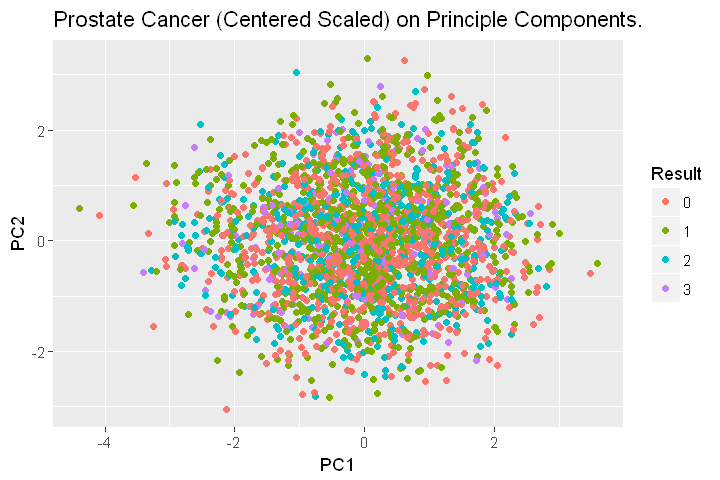

In [486]:
# Get the pre processor.
fe.PreProcessor <- caret::preProcess(training,method = c("center","scale","YeoJohnson"))

# We don't actually use this preprocessor in our predict.deep method but this show's you how the code works.
# Use the preprocessor to transform the training and the test dataset. This preprocessor model will be used to transform all unseen data as well.
tr.csyj <- predict(fe.PreProcessor,training) # training set.
ts.csyj <- predict(fe.PreProcessor,testing) # testing set.

# Let's visualise the dataset using smoe principle component analysis to get the two major axis. We will again call on a wrapper from the utilities script to do the principle component analysis for us. Inside the Udf.Utilities.Prcomp method is a simple call to stats::prcomp method. 
ggplot(Udf.Utilities.Prcomp(tr.csyj[,-ncol(tr.csyj)],nComps = 2)$components,aes(PC1,PC2,color = tr.csyj$Result)) + geom_point() + scale_color_discrete("Result") + ggtitle("Prostate Cancer (Centered Scaled) on Principle Components.")

We can see that there are no really distinct cluster groups. This is probably not a good indicator of predictability, there is absolutetly no visibility of class separation at all. There is also somewhat scattering to the outside as well, let's try using a spatial sign transform to project it radially outwards to see if we can improve the performance of the PCA.

### Step 2 :: Spatial Sign Transform
Spatial sign transforms are usually used to target outliers. But in this case, I just tried it randomly while I was frustrated about model performance, so voila. 

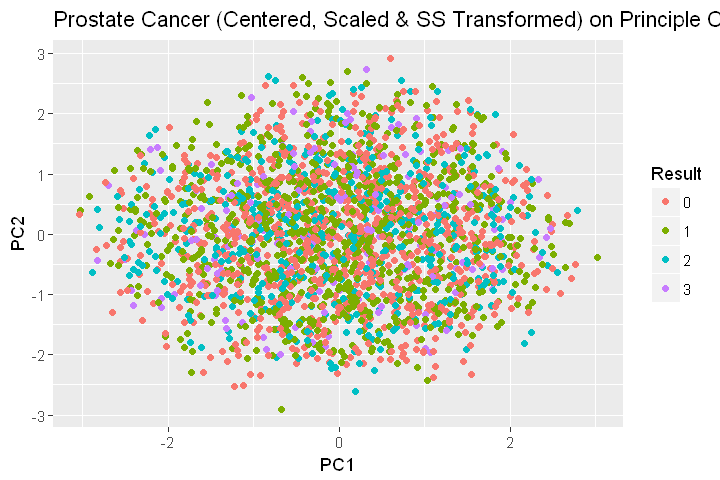

In [487]:
tr.csyj.ss <- as.data.frame(caret::spatialSign(tr.csyj[,-ncol(tr.csyj)]))
ts.csyj.ss <- as.data.frame(caret::spatialSign(ts.csyj[,-ncol(ts.csyj)]))

# Let's revisualise to see if the PCA has improved.
ggplot(Udf.Utilities.Prcomp(tr.csyj.ss,nComps = 2)$components,aes(PC1,PC2,color = tr.csyj$Result)) + geom_point() + scale_color_discrete("Result") + ggtitle("Prostate Cancer (Centered, Scaled & SS Transformed) on Principle Components")


Well, there isn't much improvement, but the data is less spread out, which is exactly what spatial sign does. 
We are going to use regularisation in our neural network, so it should automatically scale the parameters which are insiginificant down or to zero. Therefore we will bind any additonal transformations to the centered and scaled data. Let's call these binding objects as feed(s). So feed.training and feed.testing. We will hold out the label until we are at the final stage.
And yes, this is not the same as subsetting features (especially in these nonlinear models) but with the time constraint and the relatively poor computational power i have to make this model, my search grid couldn't be too big.

In [488]:
# Original data centered and scaled with a YeaJohnson transform.
feed.training <- tr.csyj[,-ncol(tr.csyj)]
feed.testing <- ts.csyj[,-ncol(tr.csyj)]  

# Bind the new data and redo column names
feed.training <- cbind(feed.training,tr.csyj.ss)
colnames(feed.training) <- paste("FT",1:ncol(feed.training),sep="")

feed.testing <- cbind(feed.testing,ts.csyj.ss)
colnames(feed.testing) <- paste("FT",1:ncol(feed.testing),sep="")

### Step 3 :: Adding the PCA Results
So far we have just been using PCA to visualise the data set. But let's include the soem of the results from the PCA as extra features. This may give it some more of the description of featurespace from the linear model of PCA.

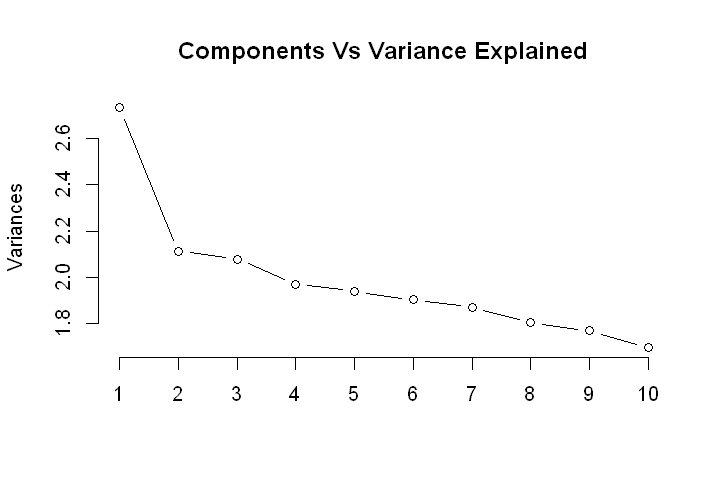

In [489]:
pcaModel_ <- Udf.Utilities.Prcomp(feed.training,nComp = ncol(feed.training))
# Look at the components and their explanation of the overall variance in the dataset.
plot(pcaModel_$prcompObj,"Components Vs Variance Explained",type = "l")

Looks like there is no 1 component which explains most of the variance. Remember our model is going to have l1 regularisation therefore it'll just simply scale the weights down to zero where variables don't actually help. So lets add the entire thing. <br />
It is important that we keep the same rotation that we learned from our training set over to the validation sets. So let's extract the rotation matrix and then multiply our validation set to get the rotated values. <br />

multiply the rotation by the matrix which is spatial sign transformed to get the next step.


In [490]:
tr.csyj.ss.pca <- pcaModel_$prcompObj$rotation * feed.training # matrix multiply the weights into the features.
feed.training <- cbind(feed.training,tr.csyj.ss.pca) # Bind the existing data.
colnames(feed.training) <- paste("FT",1:ncol(feed.training),sep="") # Generalise feature names.

ts.csyj.ss.pca <- pcaModel_$prcompObj$rotation * feed.testing
feed.testing <- cbind(feed.testing,ts.csyj.ss.pca)
colnames(feed.testing) <- paste("FT",1:ncol(feed.testing),sep="")

### Step 4 :: Row Sum of Top 2 PCA
Another useful feature may be able to be captured by the top principle components. We will use the top 2 here. This was also added because I did some random testing and found this actually helped the mean accuracy go up. 

In [491]:
tr.csyj.ss.pca.sum <- rowSums((pcaModel_$prcompObj$rotation * tr.csyj.ss.pca)[,1:2])
feed.training <- cbind(feed.training,tr.csyj.ss.pca.sum)
colnames(feed.training) <- paste("FT",1:ncol(feed.training),sep="")

ts.csyj.ss.pca.sum <- rowSums((pcaModel_$prcompObj$rotation * ts.csyj.ss.pca)[,1:2])
feed.testing <- cbind(feed.testing,ts.csyj.ss.pca.sum)
colnames(feed.testing) <- paste("FT",1:ncol(feed.testing),sep="")

### Step 5 :: Frequency Values of Features
Another useful feature is the number of counts of some of the variables and how the occur on the dataset. Given that everything is rounded to an integer, we can assume they are nearly categorical. Lets see how we do with this. We are calling on one of our utility functions, which essentiall does a count and joins it using the sqldf library.

In [492]:
tr.colsum <- my.f2cnt(training,"ATT1","ATT2")
feed.training <- cbind(feed.training,tr.colsum)
colnames(feed.training) <- paste("FT",1:ncol(feed.training),sep="")

ts.colsum <- my.f2cnt(testing,"ATT1","ATT2")
feed.testing <- cbind(feed.testing,ts.colsum)
colnames(feed.testing) <- paste("FT",1:ncol(feed.testing),sep="")

### Step 6 :: Scale and Center Everything
Once again, scale and center everything so that the NN gets nice values between 1 and -1.

In [493]:
feed.training <- scale(feed.training)
feed.testing <- scale(feed.testing)
# Rebind the labels.
feed.training <- as.data.frame(cbind(feed.training,training[,"Result"]))
colnames(feed.training)[ncol(feed.training)] <- "Result"
feed.training[,"Result"] <- as.factor(feed.training[,"Result"])
feed.testing <- as.data.frame(cbind(feed.testing,testing[,"Result"]))
colnames(feed.testing)[ncol(feed.testing)] <- "Result"
feed.testing[,"Result"] <- as.factor(feed.testing[,"Result"])

### Autoencoder.
Autoencoders are a non supervised learning implementation of neural networks. We are going to be using it as a non linear implementation of PCA. That is, reducing dimensionality of the dataset non linearly. We will use the reduced set of outputs as features to our NN supervised model.

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         48 minutes 9 seconds 
    H2O cluster version:        3.10.0.8 
    H2O cluster version age:    1 month and 24 days  
    H2O cluster name:           H2O_started_from_R_jmills_xpr226 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   1.57 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    R Version:                  R version 3.3.1 (2016-06-21) 

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


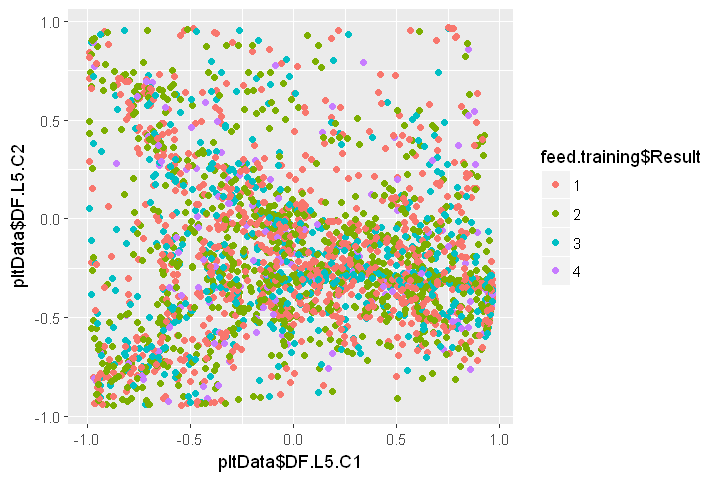

In [494]:
# Initialse h2o.
h2o.init(nthreads = -1)

# Cast the trainig and test sets as h2o objects.
h2_tr <- as.h2o(feed.training,"h2_tr")
h2_ts <- as.h2o(feed.testing,"h2_ts")


# Visualise using autoencoder.
AE <- h2o.deeplearning(
    x = 1:(ncol(feed.training) - 1),
    training_frame = h2_tr,
    hidden = c(33, 23, 13, 3, 2, 3, 13, 23, 33),
    epochs = 600,
    activation = "Tanh",
    autoencoder = TRUE,
    export_weights_and_biases = TRUE
)

# Visualise autoencoder output
tr_sup_ft <- h2o.deepfeatures(AE, h2_tr, layer = 5)
pltData <- as.data.frame(tr_sup_ft)


ggplot(pltData, aes(pltData$DF.L5.C1, pltData$DF.L5.C2, color = feed.training$Result)) + geom_point()

In [495]:
# Helper to bind features.
BindDeepFeatures <- function(features,weights){

    # Attach the autoencoder features.
    dFtMtx <- matrix(nrow = nrow(features),ncol = 13) # Genereate a container for the new features.

    ftMtx_ <- as.matrix(features) # Cast input as matrix.
    pb_ <- txtProgressBar(style = 3) # Progress bar.
    for(i in 1:nrow(ftMtx_)){

        # Drop down through teh layers.
        tmp__ <- weights[[1]] %*% ftMtx_[i,]
        tmp__ <- weights[[2]] %*% tmp__
        tmp__ <- weights[[3]] %*% tmp__

        tmp__ <- t(tmp__) # Transpose


        dFtMtx[i,] <- tmp__ # Concatenate
        setTxtProgressBar(pb_,i/nrow(ftMtx_))
        close(pb_)
    }

    boundMatrix_ <- cbind(ftMtx_,dFtMtx)

    return(as.data.frame(boundMatrix_))
}

### Step 7 :: Bind Autoencoder Output
We will simply read in the weights from a previous run, and wont't use the output from this autoencoder since it's very sensitive to the starting position. For every different autoencoder output we need to retrain our NN model downstream. 

In [496]:
# Read in the weights
ae.weights <- readRDS("AutoEncoderWeights.rds")

# Use the method we defined above to bind the features.
feed.training.deep <- BindDeepFeatures(feed.training[,-ncol(feed.training)],ae.weights)
feed.testing.deep <- BindDeepFeatures(feed.testing[,-ncol(feed.testing)],ae.weights)

  |                                                                      |   0%
  |                                                                      |   0%
  |======================================================================| 100%

In [497]:
# rebind the labels.
feed.training.deep <- as.data.frame(cbind(feed.training.deep,training[,"Result"]))
colnames(feed.training.deep)[ncol(feed.training.deep)] <- "Result"
feed.training.deep[,"Result"] <- as.factor(feed.training.deep[,"Result"])
feed.testing.deep <- as.data.frame(cbind(feed.testing.deep,testing[,"Result"]))
colnames(feed.testing.deep)[ncol(feed.testing.deep)] <- "Result"
feed.testing.deep[,"Result"] <- as.factor(feed.testing.deep[,"Result"])

## Cast as h2o object.
h2_tr <- as.h2o(feed.training.deep,"h2_tr")
h2_ts <- as.h2o(feed.testing.deep,"h2_ts")

  |======================================================================| 100%
  |======================================================================| 100%


## Training the Neural Network.
Neural networks are inherently difficult to train. They are prone to fast overfitting and the loss function is non convex with many local minima. So it's somewhat of a black art in getting it right. In this assignment alone i have built over 100 neural networks on a very very slow core i5.

In [498]:
if(isRetrainAllowed){
    dl_8 <- h2o.deeplearning(# 37.5%
    x = 1:(ncol(h2_tr) - 1),
    y = ncol(h2_tr),
    training_frame = h2_tr,
    validation_frame = h2_ts,
    distribution = "multinomial",
    activation = "MaxoutWithDropout",
    hidden = c(400, 600, 400),
    l2 = 5e-5,
    epochs = 10,
    nfolds = 10,
    balance_classes = TRUE,
    input_dropout_ratio = 0.1,
    loss = "CrossEntropy",
    classification_stop = 0.45
)


prd_8 <- h2o.predict(dl_8, h2_ts)
prd_8 <- as.data.frame(prd_8)
sum(as.numeric(prd_8$predict) == as.numeric(feed.testing.deep$Result)) / 599
}

## The predict.deep method
Below is the implementation of the predict.deep method. the code comments will explain everything that happens.

In [499]:
predict.deep <- function(data,h2oModel = NULL) {
    
    # Input parameters.
    # data :: A dataframe of the input features. Does not take ID or Response variable.

    # Assert that input featurespace must be 10 wide.
    if (ncol(data) != 10) {
        stop("Input features do not match the prostate.csv feature length. Have you forgotton to remove ID and Result columns ?")
    }

    # Assert that h2o is available 
    require(h2o)
    require(caret)
    h2o.init(nthreads = -1)
    # Assert that h2o version is correct
    if (h2o.getVersion() != "3.10.0.8") {
        stop("You have a different version of H2O, get the version 3.10.0.8")
    }


    ## Start feature engineering.

    # Step 1 feature scaling and centering with preprocessor.
    fe.preProcessor <- readRDS("fePreProcessor.rds")

    tr.csyj <- predict(fe.preProcessor, data) # make prediction on new data.


    ## Step 2 :: Spatial Sign transform
    tr.csyj.ss <- as.data.frame(caret::spatialSign(tr.csyj))

    # Bind the new data and redo column names
    feed.training <- cbind(tr.csyj, tr.csyj.ss)
    colnames(feed.training) <- paste("FT", 1:ncol(feed.training), sep = "")

    ## Step 3 :: Add PCA results
    # Read in the model
    pcaModel_ <- readRDS("pcaModel.rds")

    tr.csyj.ss.pca <- pcaModel_$prcompObj$rotation * feed.training # matrix multiply the weights into the features.
    feed.training <- cbind(feed.training, tr.csyj.ss.pca) # Bind the existing data.
    colnames(feed.training) <- paste("FT", 1:ncol(feed.training), sep = "") # Generalise feature names.

    ## Step 4 :: Row sums of 2 PCA components.
    tr.csyj.ss.pca.sum <- rowSums((pcaModel_$prcompObj$rotation * tr.csyj.ss.pca)[, 1:2])
    feed.training <- cbind(feed.training, tr.csyj.ss.pca.sum)
    colnames(feed.training) <- paste("FT", 1:ncol(feed.training), sep = "")

    ## Step 5 :: Frequency values of features
    source("FE.r")
    tr.colsum <- my.f2cnt(data, "ATT1", "ATT2")
    feed.training <- cbind(feed.training, tr.colsum)
    colnames(feed.training) <- paste("FT", 1:ncol(feed.training), sep = "")

    # Step 6 :: Scale and center everything

    feed.training <- scale(feed.training)

    # Step 7 :: Bind autoencoder output

    # Read in the autoencoder weights
    ae.weights <- readRDS("AutoEncoderWeights.rds")

    # Helper to bind features.
    BindDeepFeatures <- function(features, weights) {

        # Attach the autoencoder features.
        dFtMtx <- matrix(nrow = nrow(features), ncol = 13) # Genereate a container for the new features.

        ftMtx_ <- as.matrix(features) # Cast input as matrix.
        for (i in 1:nrow(ftMtx_)) {

            # Drop down through teh layers.
            tmp__ <- weights[[1]] %*% ftMtx_[i,]
            tmp__ <- weights[[2]] %*% tmp__
            tmp__ <- weights[[3]] %*% tmp__

            tmp__ <- t(tmp__) # Transpose


            dFtMtx[i,] <- tmp__ # Concatenate
        }

        boundMatrix_ <- cbind(ftMtx_, dFtMtx)

        return(as.data.frame(boundMatrix_))
    }

    # bind features
    feed.training.deep <- BindDeepFeatures(feed.training, ae.weights)

    # Cast h2o object.
    h2_tr <- as.h2o(feed.training.deep, "h2_tr")

    # Get the neural network model or use passed model.
    if (is.null(h2oModel)) {
        mdl_ <- h2o.loadModel("DeepLearning_model_R_1480681170824_1")
    } else {
        mdl_ <- h2oModel;
    }

    pred <- as.data.frame(h2o.predict(mdl_, h2_tr)) # return predictions as dataframe.

    return(pred[,"predict"])
}

In [500]:
pred_dl <- predict.deep(test[,c(-ncol(test))])

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         49 minutes 38 seconds 
    H2O cluster version:        3.10.0.8 
    H2O cluster version age:    1 month and 24 days  
    H2O cluster name:           H2O_started_from_R_jmills_xpr226 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   1.71 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    R Version:                  R version 3.3.1 (2016-06-21) 

  |======================================================================| 100%
  |======================================================================| 100%


In [501]:
confusionMatrix(actual, pred_dl)

Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3
         0 103  58  48   5
         1 101  71  31   1
         2  65  45  36   1
         3  17   6   9   3

Overall Statistics
                                        
               Accuracy : 0.355         
                 95% CI : (0.317, 0.395)
    No Information Rate : 0.477         
    P-Value [Acc > NIR] : 1             
                                        
                  Kappa : 0.046         
 Mcnemar's Test P-Value : 0.00000925    

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.360    0.394    0.290   0.3000
Specificity             0.646    0.683    0.767   0.9458
Pos Pred Value          0.481    0.348    0.245   0.0857
Neg Pred Value          0.526    0.725    0.806   0.9876
Prevalence              0.477    0.300    0.207   0.0167
Detection Rate          0.172    0.118    0.060   0.0050
Detection Prevalence    0.357    0.340    

---
# 13. Ensemble the Predictions

In [502]:
# create a dataframe to store each of the predictions from each of the models we want to ensemble
preds_df <- data.frame(matrix(ncol = 0, nrow =600))

In [503]:
preds_df$pred_knn <- pred_knn
preds_df$pred_rf <- pred_rf
preds_df$pred_dl <- pred_dl
preds_df$pred_rules <- pred_rules
preds_df$pred_xgb <- pred_xgb

In [504]:
head(preds_df)

,pred_knn,pred_rf,pred_dl,pred_rules,pred_xgb
1,1,1,0,1,1
2,1,1,2,2,1
3,1,0,0,1,1
4,1,1,1,1,1
5,1,0,1,2,1
6,0,1,2,1,0


In [505]:
table(preds_df$pred_xgb)


  0   1   2   3 
245 238 101  16 

In [506]:
preds_df <- Udf.Utilities.MajorityVotePredictions(preds_df)

In [507]:
confusionMatrix(actual, preds_df$majority_pred)

Confusion Matrix and Statistics

          Reference
Prediction   0   1   2   3
         0 114  96   4   0
         1 101  98   5   0
         2  81  57   9   0
         3  22  13   0   0

Overall Statistics
                                       
               Accuracy : 0.368        
                 95% CI : (0.33, 0.408)
    No Information Rate : 0.53         
    P-Value [Acc > NIR] : 1            
                                       
                  Kappa : 0.034        
 Mcnemar's Test P-Value : NA           

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3
Sensitivity             0.358    0.371   0.5000       NA
Specificity             0.645    0.685   0.7629   0.9417
Pos Pred Value          0.533    0.480   0.0612       NA
Neg Pred Value          0.472    0.581   0.9801       NA
Prevalence              0.530    0.440   0.0300   0.0000
Detection Rate          0.190    0.163   0.0150   0.0000
Detection Prevalence    0.357    0.340   0.2450   

---
# 14. Classifier Summary Report

### XGBoost and Random Forest
We have chosen two variants on the Decision Tree paradigm for a our first models. While Gradient Boosted trees and Random Forests are based on the same concept, their behaviours were shown to be quite different.

Given the less 'random' nature of Boosting, more effort is required to tune the many parameters to ensure there is no overfitting - whilst RandomForests are pretty good in this area out of the box. The only parameter to tune is really the number of features that are randomly selected from at each step in the tree creation. After tuning we saw that the relatively low number of 2 was selected - the default is the square root of the number of predictors, so 3 or 4 in our case.

Both options gave us the ability to see feature importance and agreed that ATT1 and ATT5 were not very significant. Dropping these improved the RandomForest accuracy.

Both models performed faily well, but XGBoost took a lot more effort to get to this accuracy. The best choice for this project is a little subjective (even after we've run both):

Dimensiality - Boosted trees are the method of choice in low (< 100) dimension settings. Random forests are the better choice in high-dimension settings.

Ideally, at the end of the project we would like to be able to convey how the prediction model is working under the hood to doctors who use it. They will be able to bring domain expertise to the problem if they can see how the model is working. This is one benefit of using a Tree based model. This is reduced somewhat as we bring in aspects such as Boosting and Random Forests, however.

After using the method, we were unable to improve the predictive accuracy much beyond 34%. Much of this was due to not having the compute power to effectively tune the hyperparameters. Given we were very unsure about our data, we needed to tune heavily, especially since we were seeing many cases of train error rates much lower than test. Avoiding over-fitting proved to be the demise of this method.

### KNN
As was shown during the principal component analysis stage of the Deep Learning model - we could see the the PCA output on 2 components had a tight grouping of each of the cancer clusters, however they don't have a general skewness to either side. This indicated that the decision boundaries are very non-linear. But it also shows that each of the cancer levels are spread but have really tiny clusters. Which means if you find the most common K on which they are clustered, the model would perform well. 

This proved to be the case with KNN performing quite well comparatively.

### FDA and SVM
Flexible Discriminant Analysis (FDA) was selected as FDA is not adversely affected by non-informative predictors hence not requiring feature selection tools (James, Witten, Hastie, & Tibshirani, 2015). When FDA was implemented on the prostate cancer test dataset, it showed poor accuracy at around 20%. This is due to the complexity in the FDA implementation. Using the 'caret' package to train the FDA model was complicating requiring the 'mda' package which in turn used the 'earth' package. In order to get FDA model learning required over 7 hours to implement due to the 3 packages involved. Lesson learnt, set "pmethod = 'none'" which is an earth() parameter used to prune the model but tune the model via train() function from the 'caret' package.
 
Support Vector Machine (SVM) was expected to perform better than results obtained. The issue with SVM was the number of turning parameter while using polynomial, the tuning parameters being scale, degree and cost. Also SVM is sensitive to non-informative predictors requiring feature selection tools. The 'caret' package was implemented but search time was high hence forcing polynomial degree to 1 with all predictors included (excluding 'ID') to be used in the SVM model. In other words if more time was allowed the SVM model accuracy would be improved due to the ability to run longer computational searches.

### Feed Forward Deep Learning Model Challenges
There were a number of challenges developing the deep learning model. Firstly, the computational requirements of the deep learning models are quite high at training time. The training system was a now outdated Intel Core i5 with 8GB of memory. This meant that there was no option to do single thread operations due to the large number of neurons in the hidden layer. The only option was to utilise h2o library which provided a multi threaded solution via the Java traintime environment. <br />
Even with multi threading, grid searching for hyper parameters was extremely difficult. Much of the time the grid model would error out due to memory constraints and or computational errors propergating out to the operating system (these include java runtime exceptions, and IDE C++ runtime exceptions). <br />
Secondly, the tuning of hyper parameters is extremely difficult (at least given the current time constraints). Hyperparameters that were tuned are : <br />
1. Nueron activation function type.
2. Number of hidden layers and neurons in each layer.
3. Regularisation method and strength.
4. Number of passes.
5. Number of folds in cross validation.
6. Feature drop out in pass.
There are a host of other parameters which could be tuned to achive better performance however given the time constraints, were not investigated. <br />
As to expected, the model accuracy was very sensitive to the Nueron activation function and the hidden layers and neurons in the layers. The number of folds and the regularisation strength also played a crucial part in model accuracy control.<br />
One of the more interesting situations we're the auto encoder output which represented a unique challenge. Due to the multi threaded design of the model, the autoencoder seed was not able to be set. Which meant the output of the autoencoder was changing every new instance it was run. So there were instances that the autoencoder output was very favourable to the network model and increase in validation set accuracy of upto 41% was achieved. However, when the transform was not favourable, the precision fell back down to as low as 30%. <br />
To counter this affect the weights were extracted and used to transform the data the same way everytime. However, once this was identified, it represented not enough time to reparameterise the network to optimal.

### Non-linearity

During our EDA and feature engineering stages we were able to prove that we had issues of non-linearity between our predictors and response variables - this forced our hand in terms of model selection towards some of the more complex options, such as KNN and Deep Learning methods. This will reduce interpretability, but this was a necessity since simpler, linear based models would have performed very poorly.

### Summary of Classification Performances per model

| Model                                | Accuracy             |
| ------------------------------------ | -------------------- |
| XGBoost pre-cross valdation tuned    | **0.31**  |
| XGBoost post-cross validation tuned  | ** 0.332** |    
| RandomForest pre-feature selection   | **0.325** |
| RandomForest post-feature selection  | **0.35**  |
| XGBoost with PCA                     | **0.283** |
| GBM                                  | **0.288** |
| KNN                                  | **0.358** |
| Classification Trees                 | **0.272** |
| Rule-based model                     | **0.31**  |
| Deep Learnng                         | **0.328** | 




### Final result of the Ensemble
We ensembled our top 5 models using majority vote (mode) and improved our accuracy to **36.8%**

# References <a class="anchor" id="References"></a>

James, G., Witten, D., Hastie, T., Tibshirani, R. (2015). "Introduction to Statistical Learning with Applications in R". New York: Springer.  

Kuhn, M., Johnson, K. (2013). "Applied Predictive Modeling", New York: Springer.